In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "039"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 300  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.0)
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.1
model = models.qwen_14b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 32
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0001 --port=8000 --api-key=default
INFO 02-23 01:07:34 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 01:07:35 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 01:07:35 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.48it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.50it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.51it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.05it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.02it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.80it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.67it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.61it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.68it/s]



(VllmWorkerProcess pid=24020) INFO 02-23 01:07:55 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 01:07:55 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=24020) INFO 02-23 01:07:57 worker.py:267] Memory profiling takes 2.61 seconds
(VllmWorkerProcess pid=24020) INFO 02-23 01:07:57 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=24020) INFO 02-23 01:07:57 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 01:07:57 worker.py:267] Memory profiling takes 2.61 seconds
INFO 02-23 01:07:57 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 01:07:57 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [23636]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 01:08:48 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:41338 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:53<00:00,  1.17it/s, completion_tokens=820, prompt_tokens=1483, reward=0.295, acc=0.295, early_stop=0.0269, token_logprobs=1.3e+6]


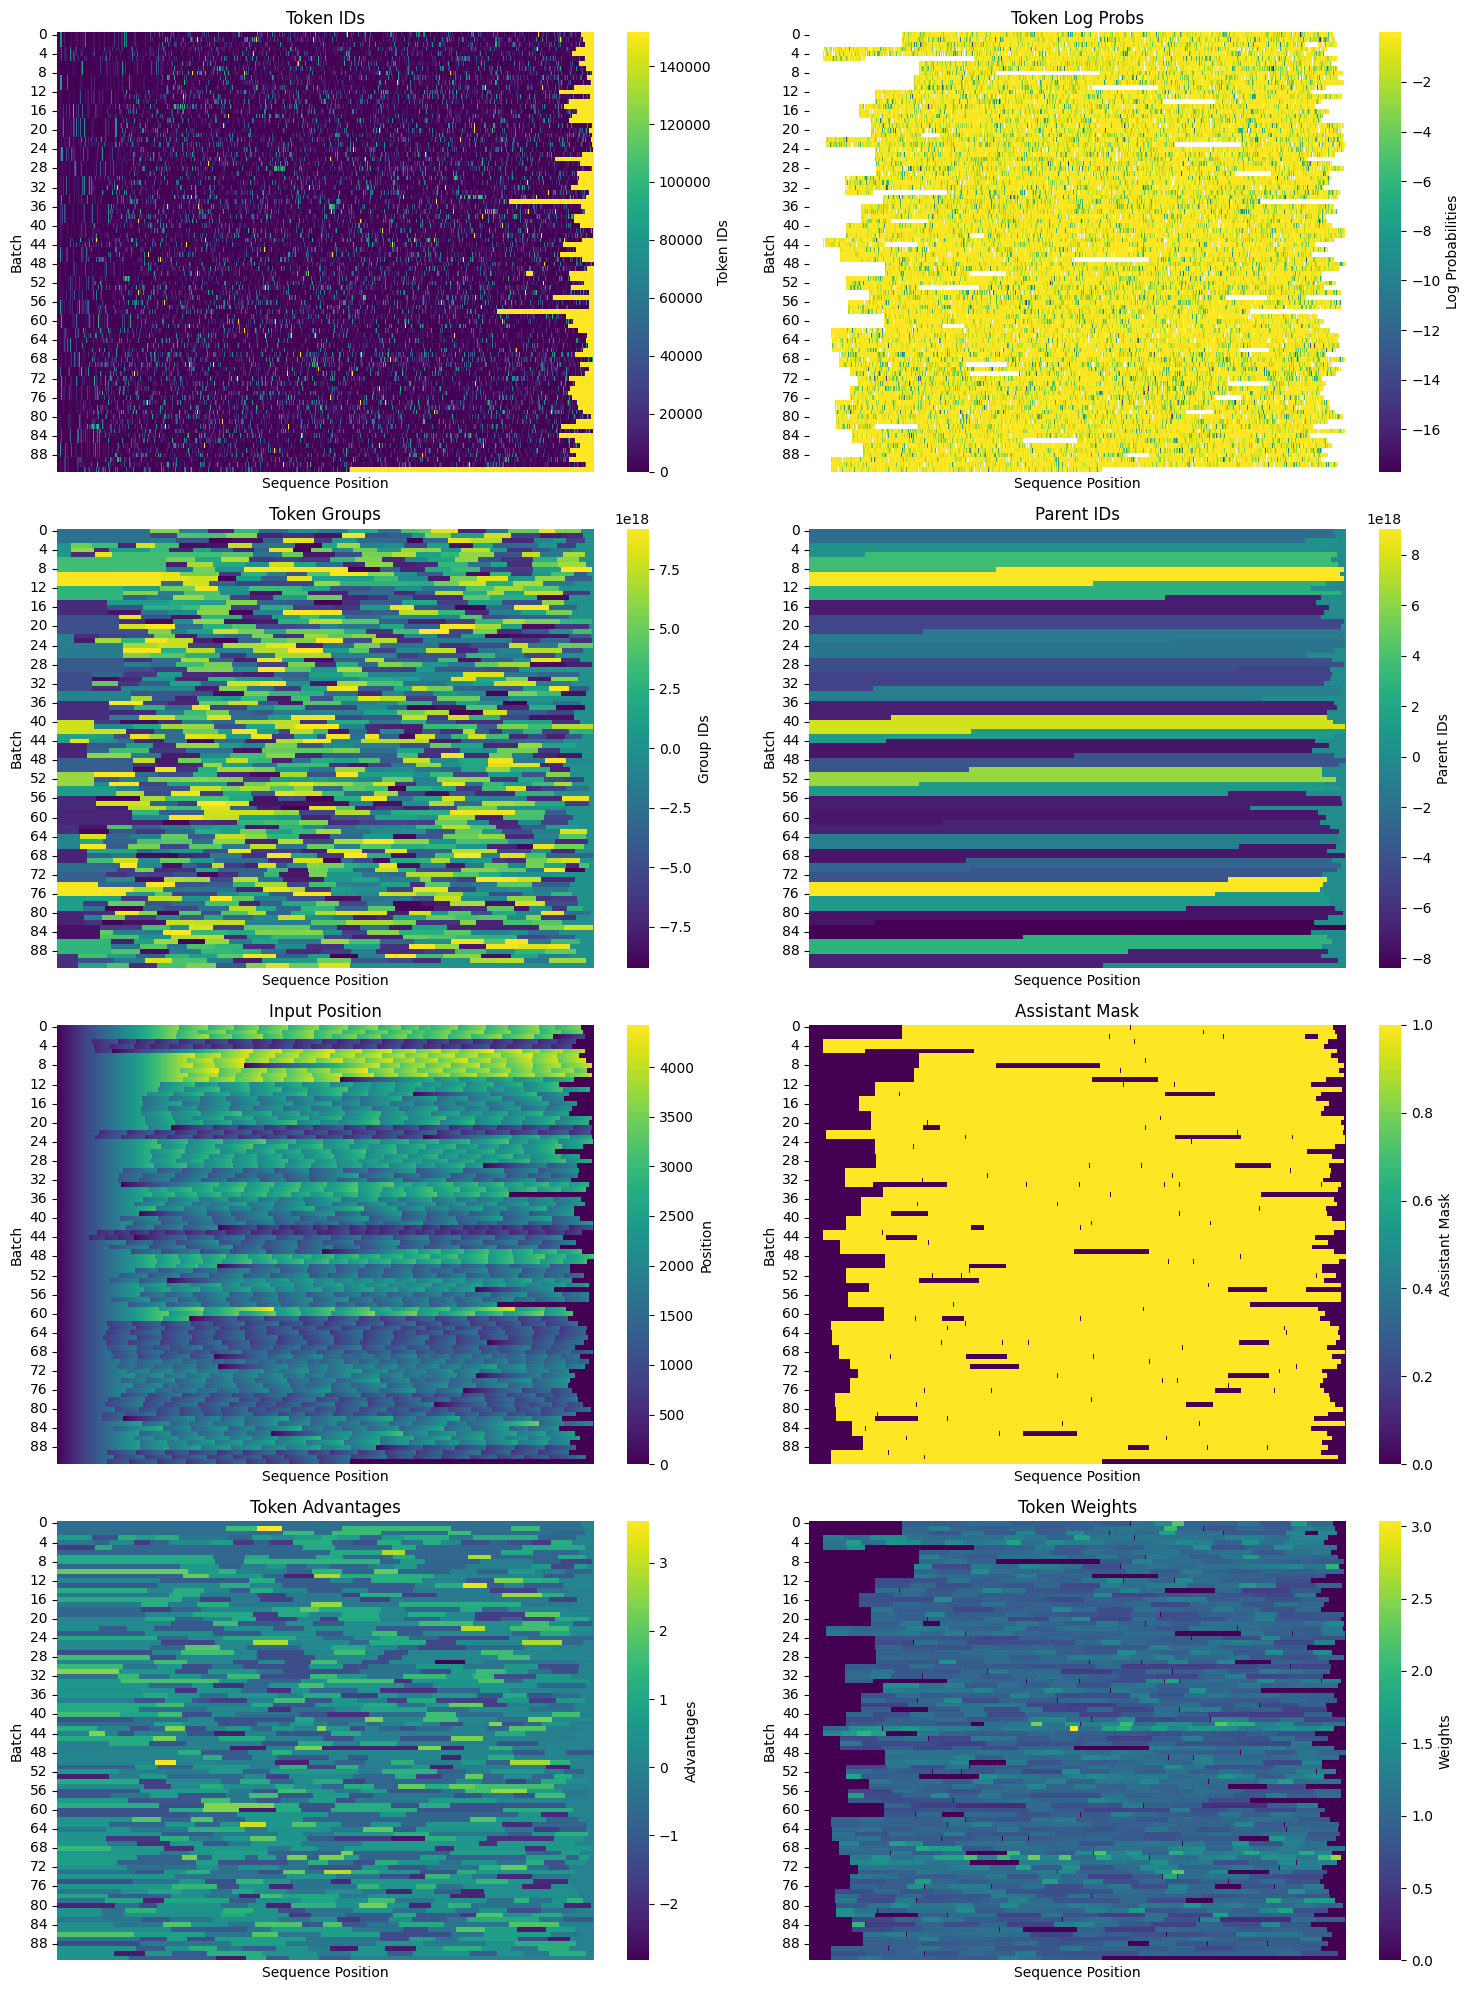

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 01:14:09.276000 26546 torch/distributed/run.py:793] 
W0223 01:14:09.276000 26546 torch/distributed/run.py:793] *****************************************
W0223 01:14:09.276000 26546 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 01:14:09.276000 26546 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0001
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-00008

Writing logs to models/039/logs/log_1740273254.txt


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 28.20 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|23|Loss: -0.0004: 100%|██████████| 23/23 [12:52<00:00, 32.56s/it, entropy=0.826, kl_div=nan, loss=-0.000434, policy=-0.000434]INFO:torchtune.utils._logging:S

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0002 --port=8000 --api-key=default
INFO 02-23 01:28:47 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 01:28:48 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 01:28:48 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.50it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.50it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.52it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.08it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.05it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.84it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.72it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.66it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.72it/s]



(VllmWorkerProcess pid=36679) INFO 02-23 01:29:10 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 01:29:10 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=36679) INFO 02-23 01:29:13 worker.py:267] Memory profiling takes 3.48 seconds
(VllmWorkerProcess pid=36679) INFO 02-23 01:29:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=36679) INFO 02-23 01:29:13 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 01:29:13 worker.py:267] Memory profiling takes 3.57 seconds
INFO 02-23 01:29:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 01:29:13 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [34789]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 01:30:04 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:56100 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:02<00:00,  2.49it/s, completion_tokens=818, prompt_tokens=1188, reward=0.355, acc=0.355, early_stop=0.00688, token_logprobs=1306401]


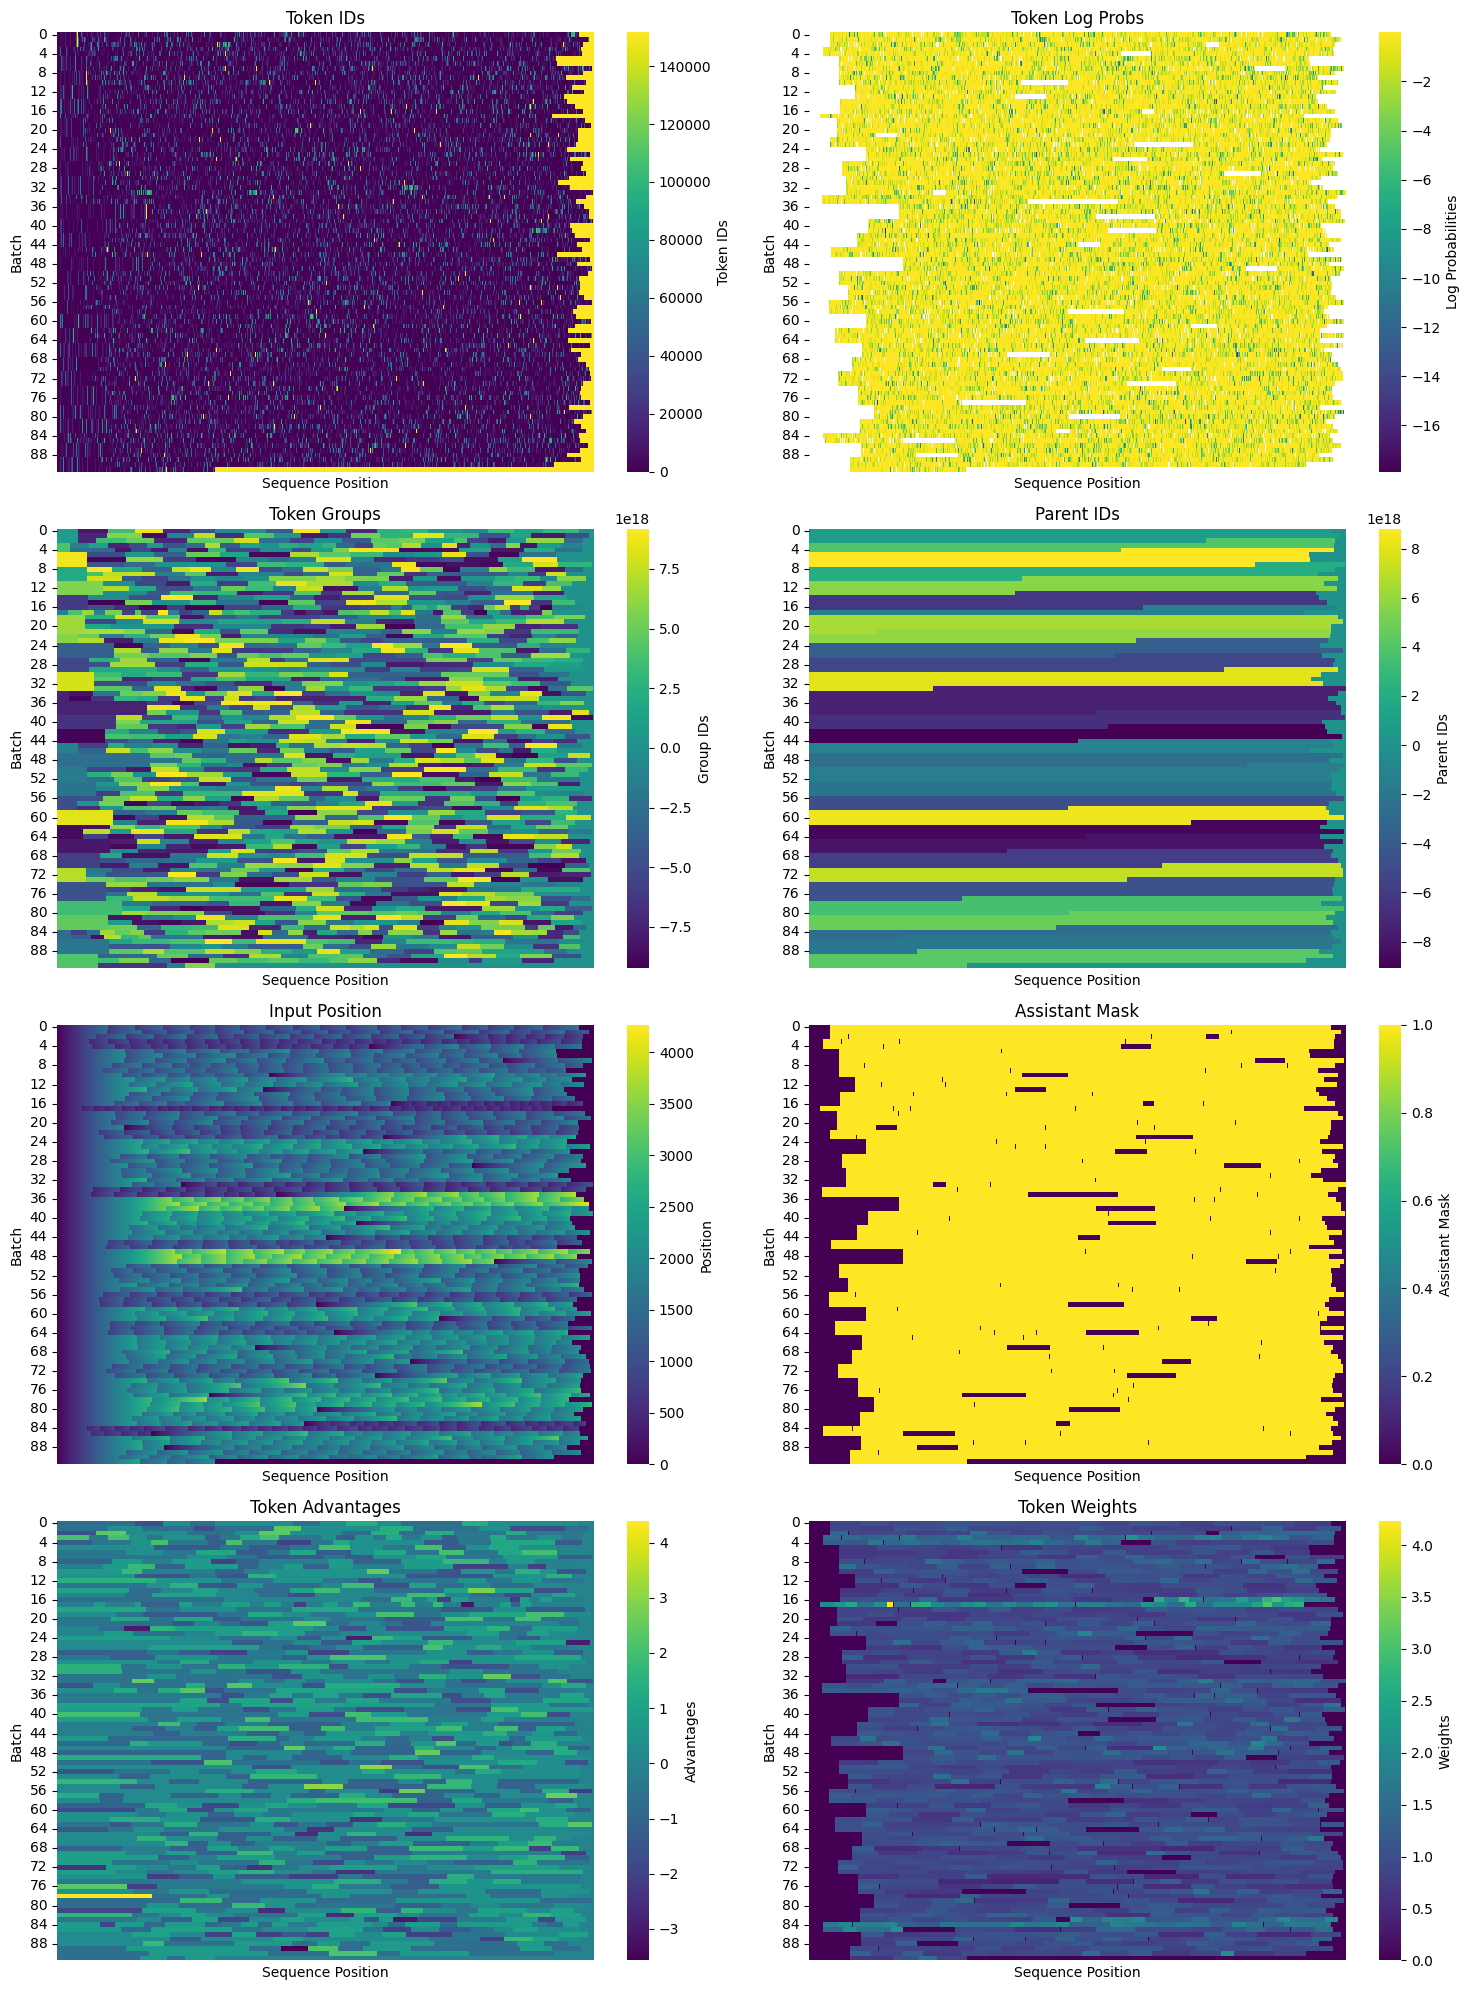

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 01:34:33.899000 39259 torch/distributed/run.py:793] 
W0223 01:34:33.899000 39259 torch/distributed/run.py:793] *****************************************
W0223 01:34:33.899000 39259 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 01:34:33.899000 39259 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0002
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.saf

Writing logs to models/039/logs/log_1740274478.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.61 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|23|Loss: 0.0000: 100%|██████████| 23/23 [12:52<00:00, 32.63s/it, entropy=0.815, kl_div=nan, loss=1.24e-5, policy=1.24e-5]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0003 --port=8000 --api-key=default
INFO 02-23 01:49:10 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 01:49:11 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 01:49:11 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.52it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.53it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.55it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.11it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.07it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.86it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.74it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.67it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.74it/s]



INFO 02-23 01:49:33 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=48667) INFO 02-23 01:49:33 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=48667) INFO 02-23 01:49:37 worker.py:267] Memory profiling takes 3.42 seconds
(VllmWorkerProcess pid=48667) INFO 02-23 01:49:37 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=48667) INFO 02-23 01:49:37 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 01:49:37 worker.py:267] Memory profiling takes 3.49 seconds
INFO 02-23 01:49:37 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 01:49:37 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [46776]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 01:50:26 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:57456 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:12<00:00, 11.02it/s, completion_tokens=809, prompt_tokens=1346, reward=0.336, acc=0.336, early_stop=0.00688, token_logprobs=1292496]
Deleted iteration directory ./models/039/0002


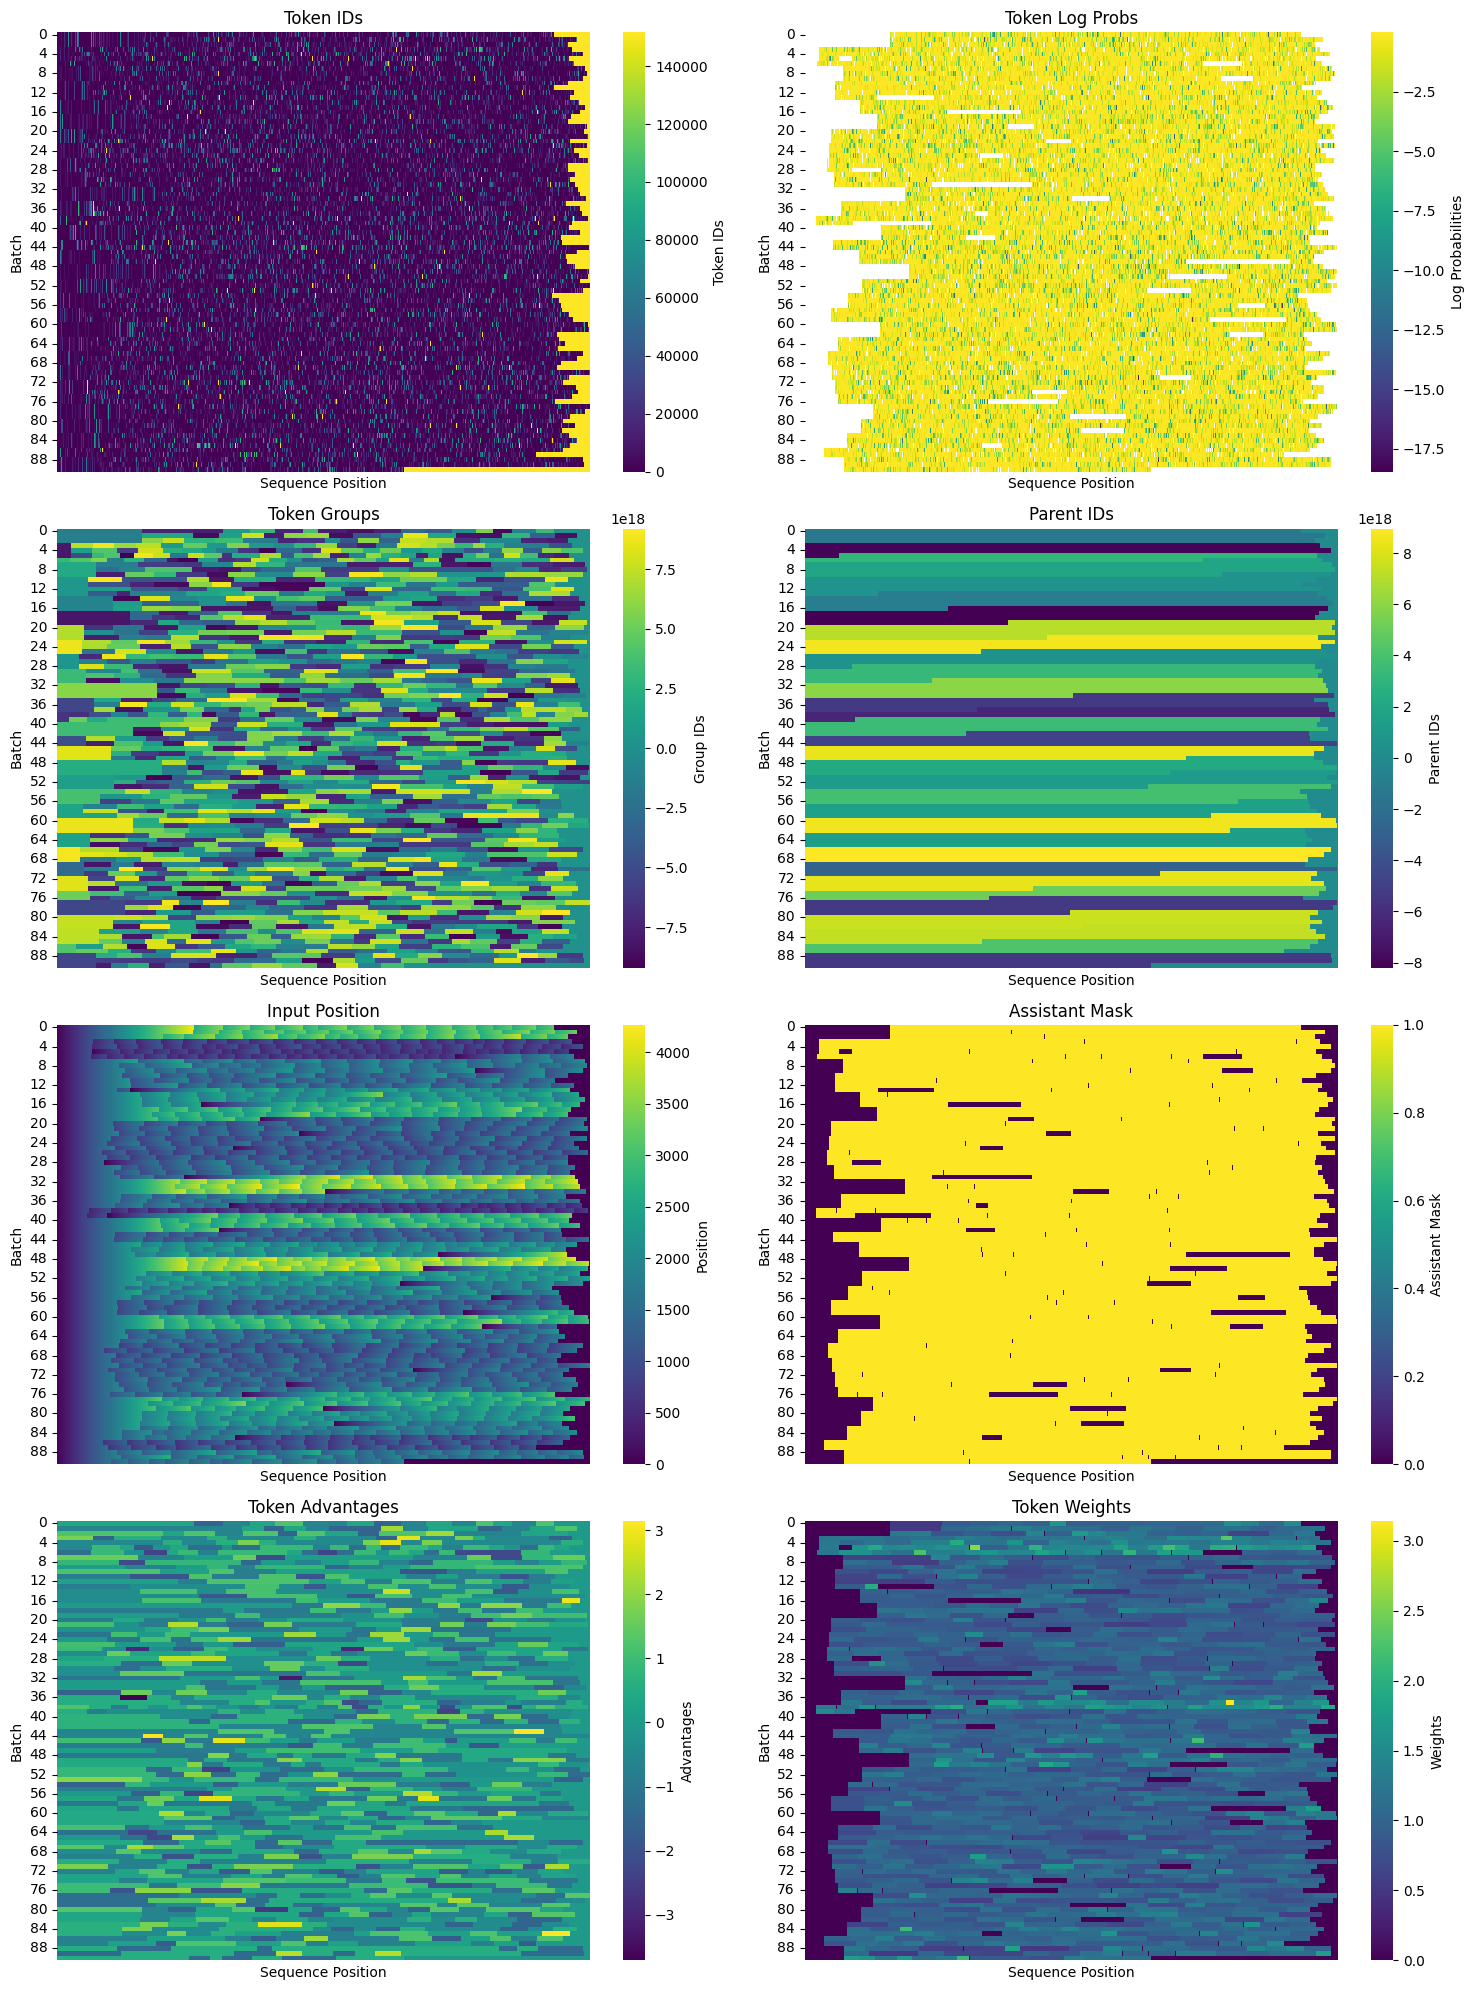

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 01:55:08.809000 51487 torch/distributed/run.py:793] 
W0223 01:55:08.809000 51487 torch/distributed/run.py:793] *****************************************
W0223 01:55:08.809000 51487 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 01:55:08.809000 51487 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0003
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-00008

Writing logs to models/039/logs/log_1740275713.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.59 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|23|Loss: -0.0031: 100%|██████████| 23/23 [12:53<00:00, 32.67s/it, entropy=0.879, kl_div=nan, loss=-0.00311, policy=-0.00311]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0004 --port=8000 --api-key=default
INFO 02-23 02:09:46 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 02:09:47 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 02:09:47 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.52it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.55it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.56it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.12it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.09it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.86it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.74it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.67it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.75it/s]



(VllmWorkerProcess pid=60933) INFO 02-23 02:10:09 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 02:10:09 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=60933) INFO 02-23 02:10:13 worker.py:267] Memory profiling takes 3.38 seconds
(VllmWorkerProcess pid=60933) INFO 02-23 02:10:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=60933) INFO 02-23 02:10:13 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 02:10:13 worker.py:267] Memory profiling takes 3.46 seconds
INFO 02-23 02:10:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 02:10:13 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [59068]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 02:11:07 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-23 02:11:07 metrics.py:455] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-23 02:11:07 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:55778 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:17<00:00,  1.91it/s, completion_tokens=847, prompt_tokens=1133, reward=0.357, acc=0.357, early_stop=0.00313, token_logprobs=1355277]
Deleted iteration directory ./models/039/0001


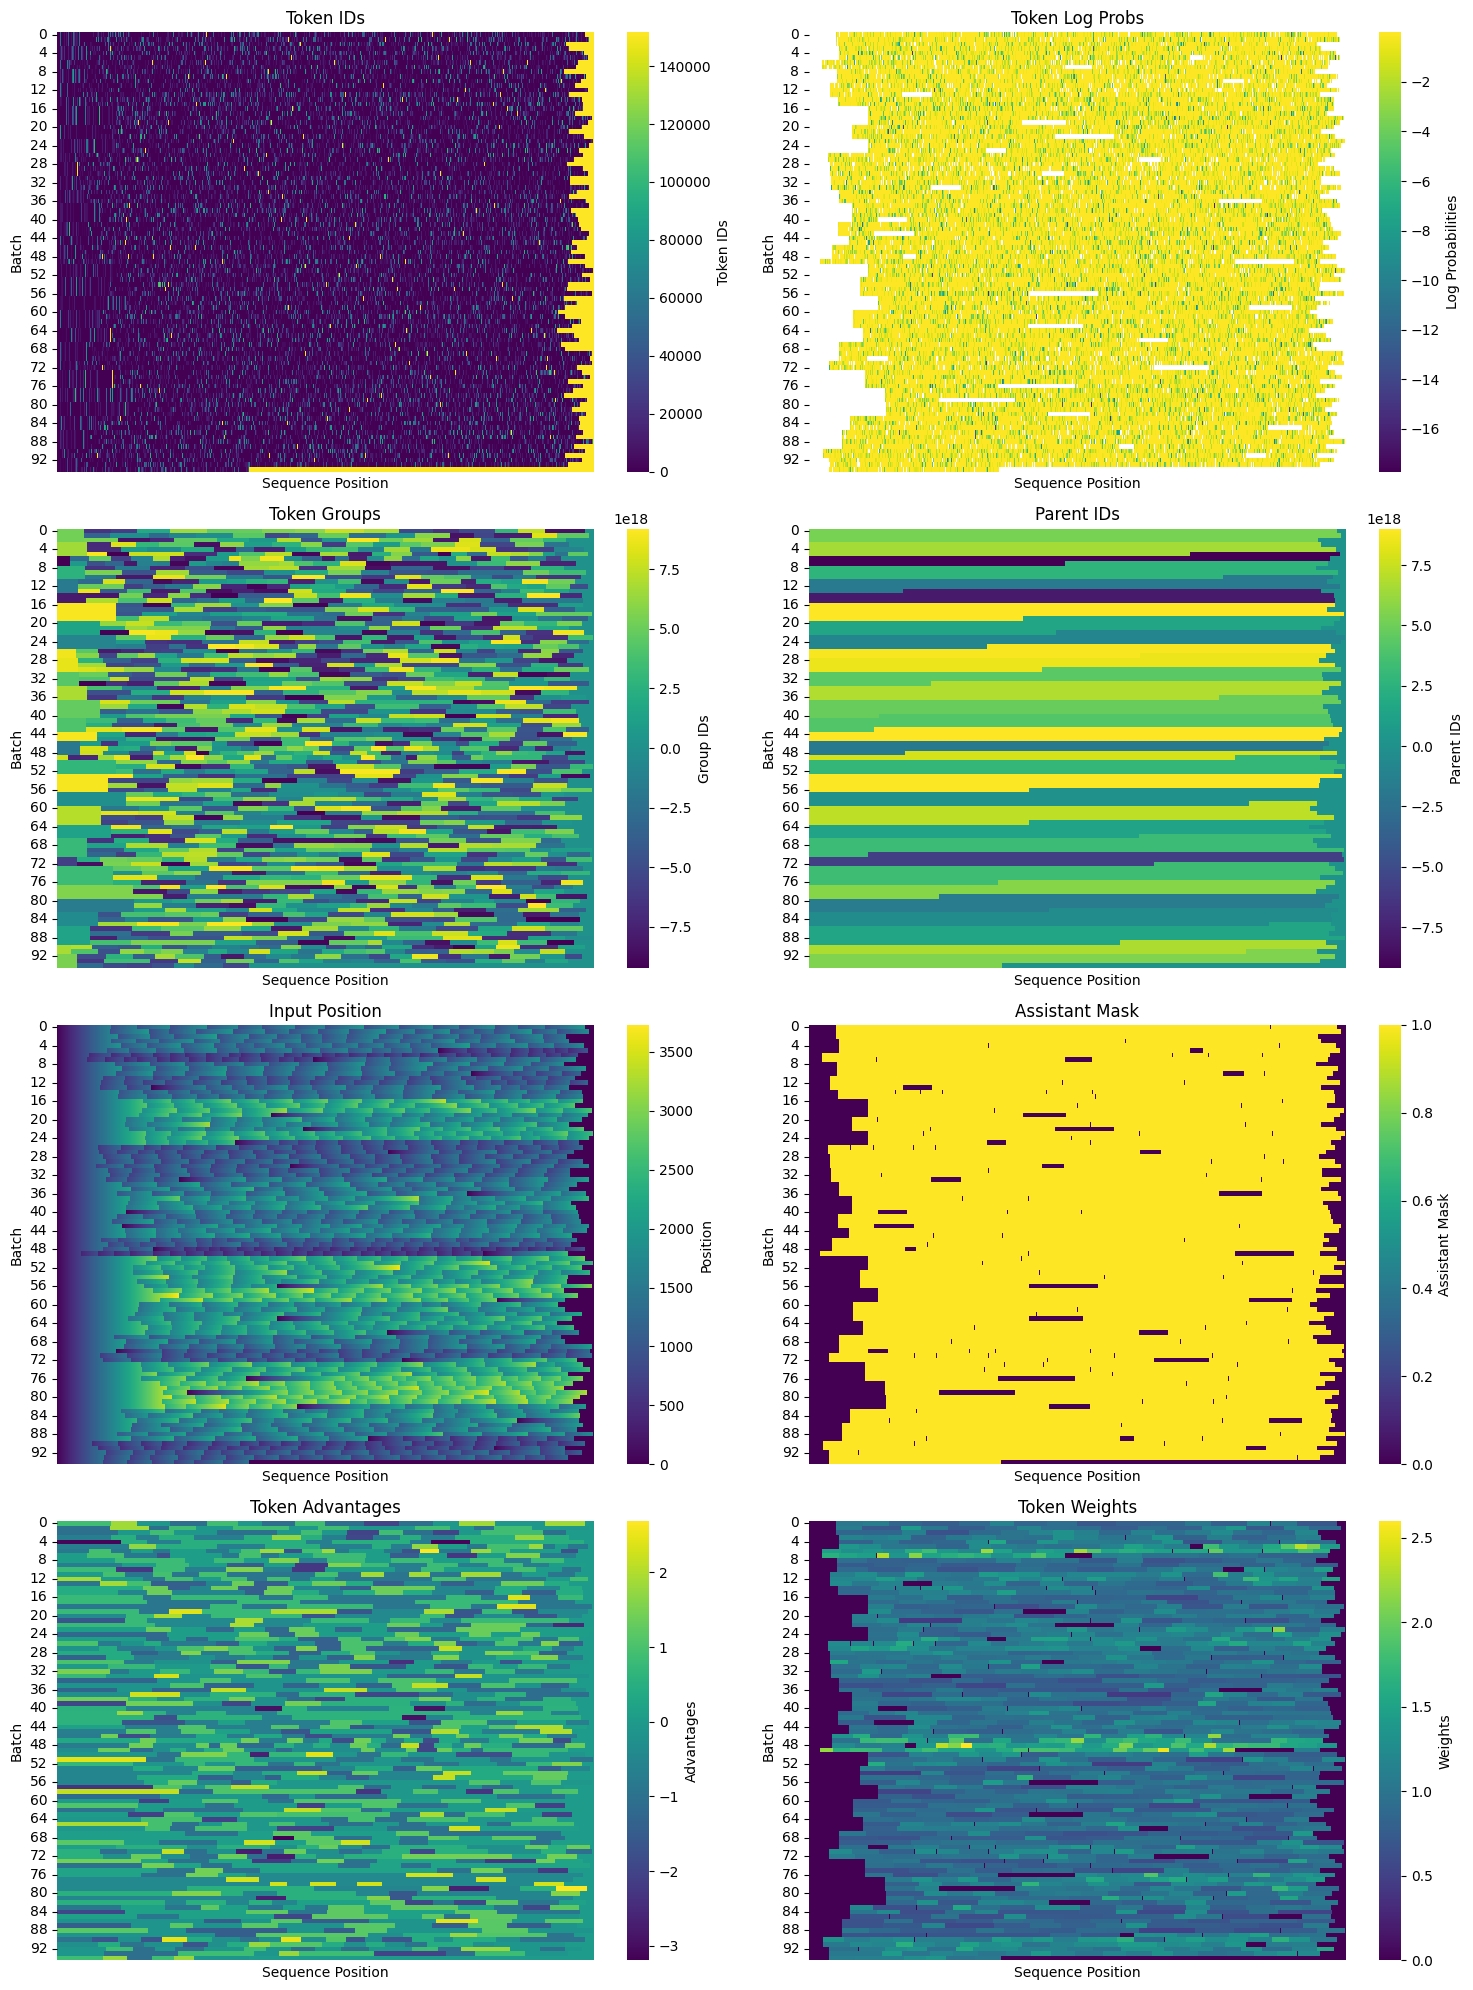

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 02:15:56.271000 63658 torch/distributed/run.py:793] 
W0223 02:15:56.271000 63658 torch/distributed/run.py:793] *****************************************
W0223 02:15:56.271000 63658 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 02:15:56.271000 63658 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0004
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-00008

Writing logs to models/039/logs/log_1740276961.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 27.14 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|24|Loss: -0.0005: 100%|██████████| 24/24 [13:26<00:00, 32.62s/it, entropy=0.594, kl_div=nan, loss=-0.00051, policy=-0.00051]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0005 --port=8000 --api-key=default
INFO 02-23 02:31:07 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 02:31:08 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 02:31:08 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.53it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.54it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.10it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.08it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.87it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.74it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.68it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.74it/s]



INFO 02-23 02:31:30 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=73289) INFO 02-23 02:31:30 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=73289) INFO 02-23 02:31:33 worker.py:267] Memory profiling takes 3.31 seconds
(VllmWorkerProcess pid=73289) INFO 02-23 02:31:33 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=73289) INFO 02-23 02:31:33 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 02:31:33 worker.py:267] Memory profiling takes 3.39 seconds
INFO 02-23 02:31:33 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 02:31:33 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [71404]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 02:32:27 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-23 02:32:27 metrics.py:455] Avg prompt throughput: 4.9 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-23 02:32:27 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:52664 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:33<00:00,  5.79it/s, completion_tokens=857, prompt_tokens=1354, reward=0.412, acc=0.412, early_stop=0.005, token_logprobs=1369348]
Deleted iteration directory ./models/039/0003


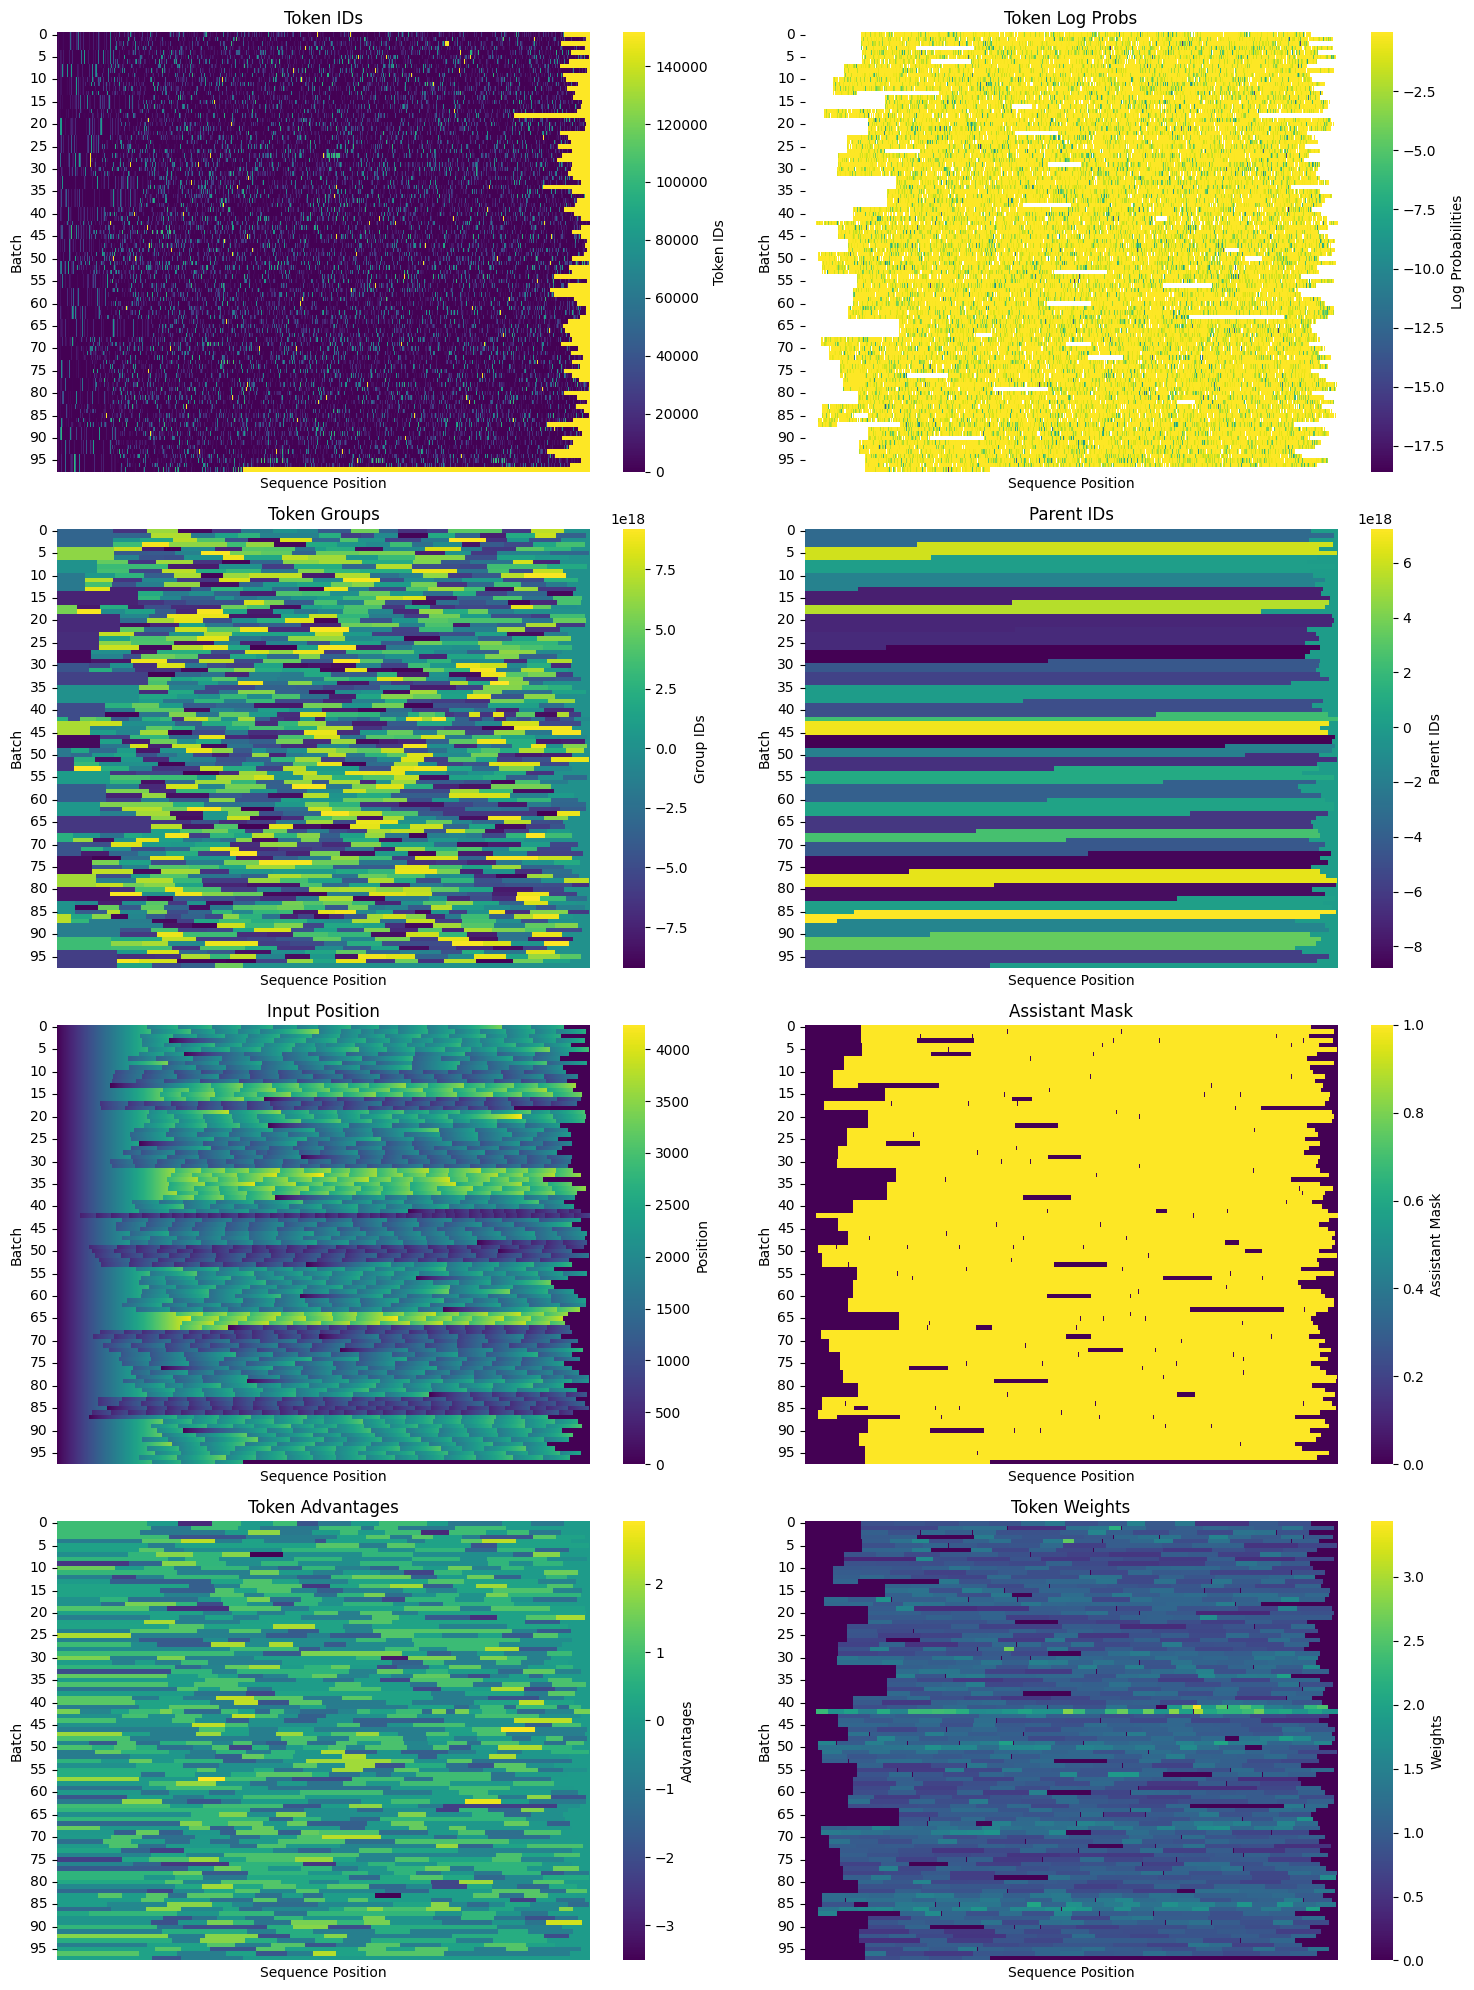

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 02:37:32.689000 76084 torch/distributed/run.py:793] 
W0223 02:37:32.689000 76084 torch/distributed/run.py:793] *****************************************
W0223 02:37:32.689000 76084 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 02:37:32.689000 76084 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0005
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-00008

Writing logs to models/039/logs/log_1740278257.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.60 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|24|Loss: 0.0003: 100%|██████████| 24/24 [13:26<00:00, 32.62s/it, entropy=0.746, kl_div=nan, loss=0.000254, policy=0.000254]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0006 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0006 --port=8000 --api-key=default
INFO 02-23 02:52:43 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 02:52:44 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 02:52:44 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0006', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.55it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.57it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.57it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.14it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.12it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.90it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.78it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.71it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.78it/s]



(VllmWorkerProcess pid=85928) INFO 02-23 02:53:05 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 02:53:05 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=85928) INFO 02-23 02:53:09 worker.py:267] Memory profiling takes 3.38 seconds
(VllmWorkerProcess pid=85928) INFO 02-23 02:53:09 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=85928) INFO 02-23 02:53:09 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 02:53:09 worker.py:267] Memory profiling takes 3.38 seconds
INFO 02-23 02:53:09 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 02:53:09 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [84050]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 02:54:00 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55654 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:59<00:00,  2.80s/it, completion_tokens=876, prompt_tokens=1472, reward=0.37, acc=0.37, early_stop=0.000625, token_logprobs=1.4e+6]
Deleted iteration directory ./models/039/0005


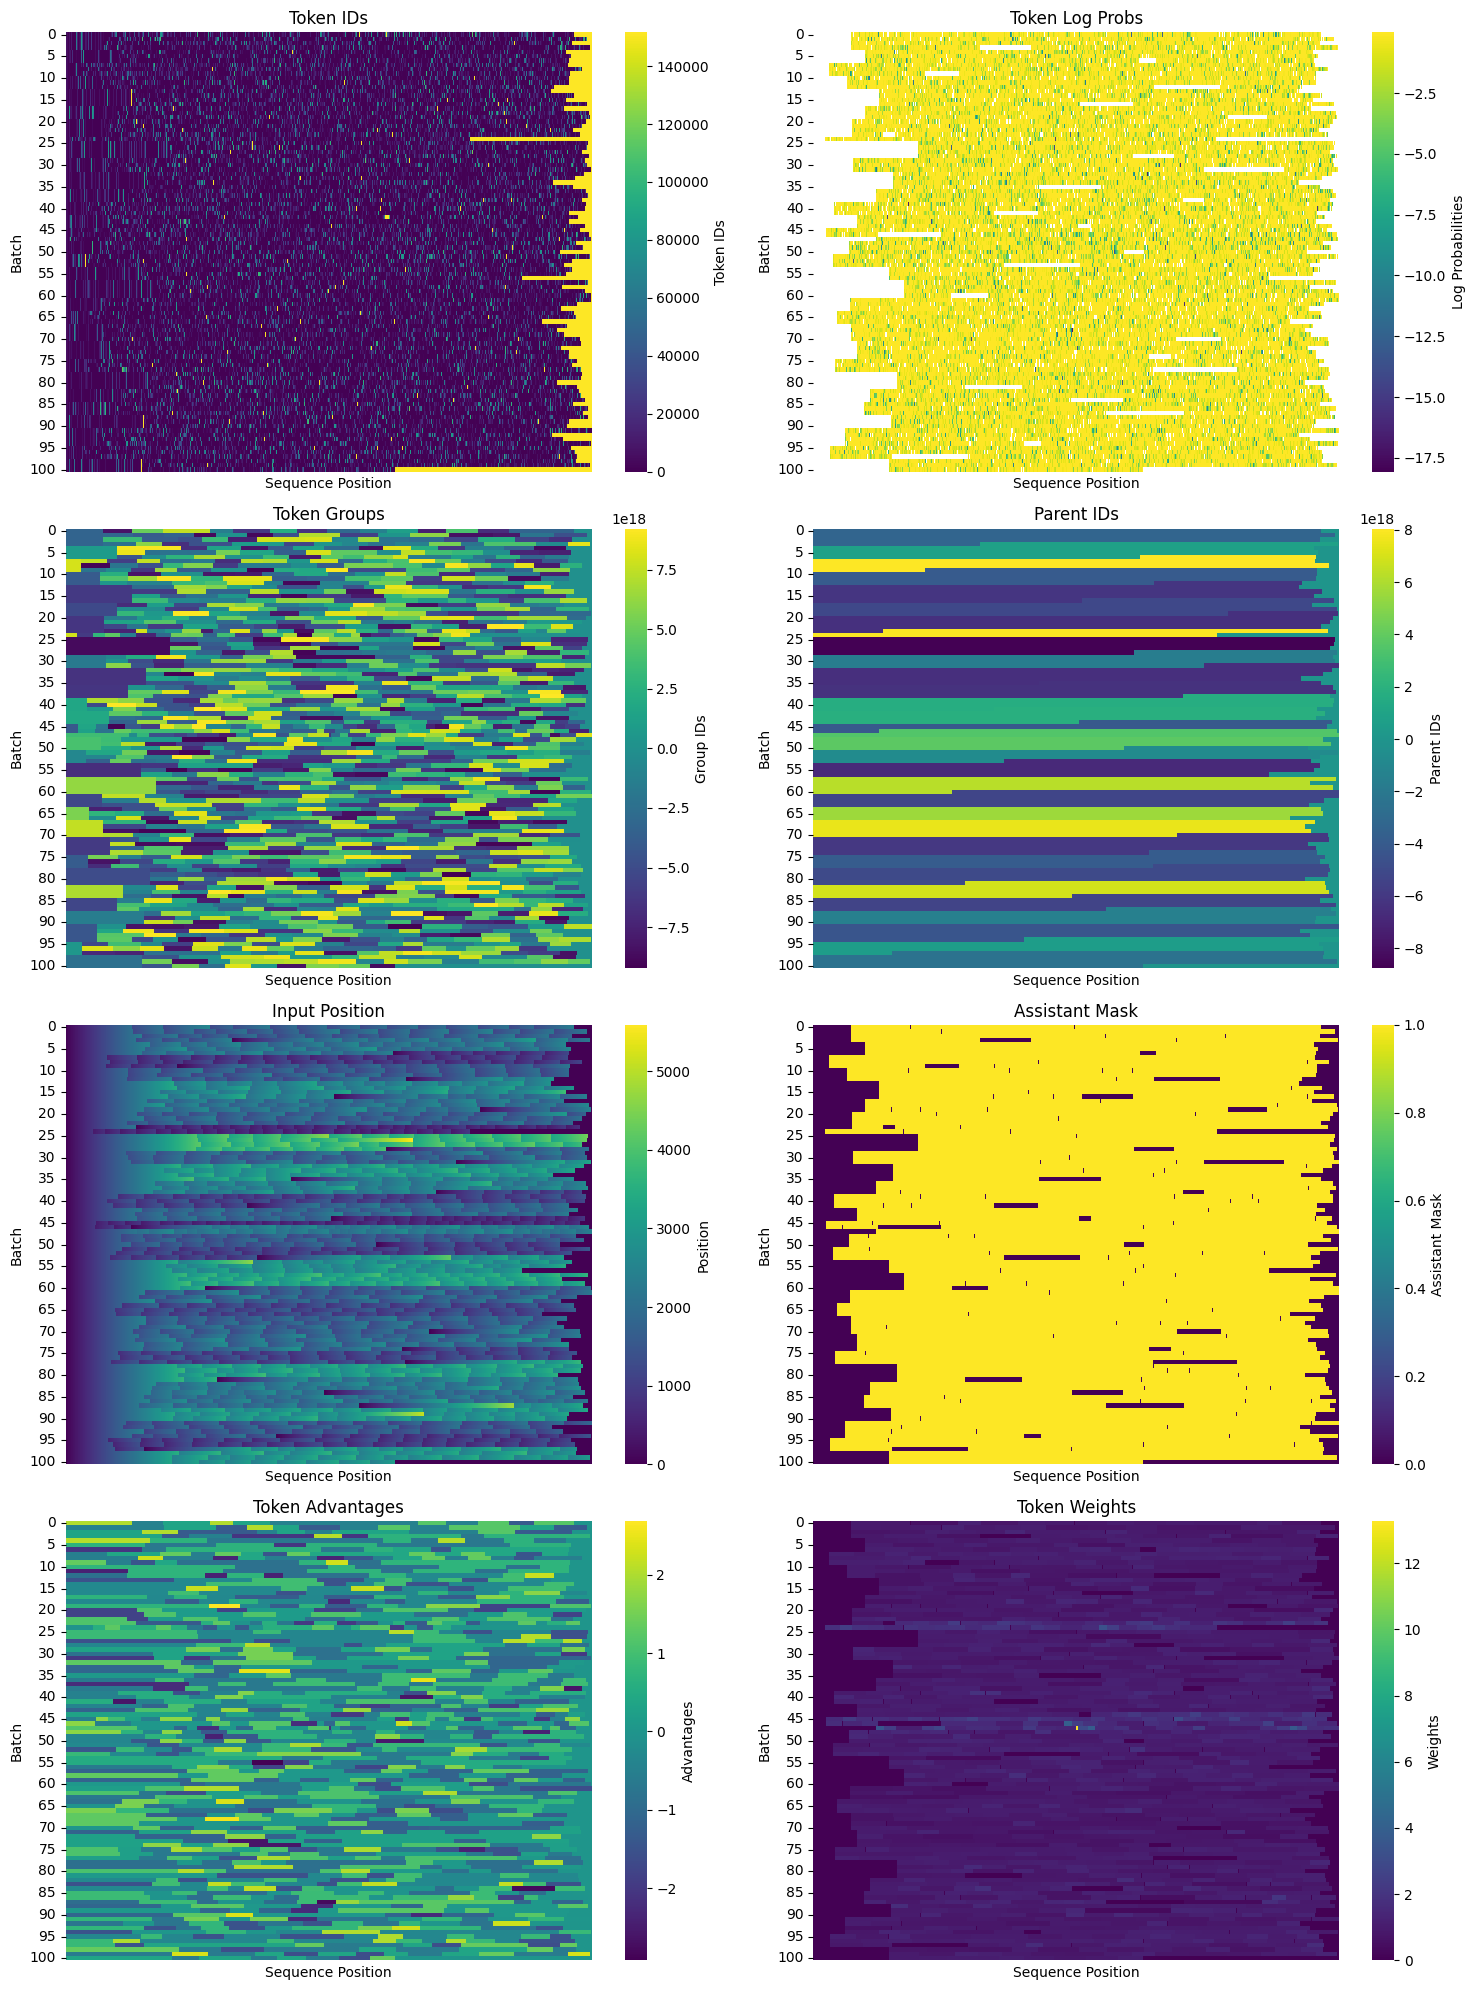

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 02:59:32.637000 89327 torch/distributed/run.py:793] 
W0223 02:59:32.637000 89327 torch/distributed/run.py:793] *****************************************
W0223 02:59:32.637000 89327 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 02:59:32.637000 89327 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0006
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.saf

Writing logs to models/039/logs/log_1740279577.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.89 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|25|Loss: 0.0006: 100%|██████████| 25/25 [13:58<00:00, 32.67s/it, entropy=0.743, kl_div=nan, loss=0.000646, policy=0.000646] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0007 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0007 --port=8000 --api-key=default
INFO 02-23 03:15:15 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 03:15:16 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 03:15:16 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0007', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.52it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.55it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.56it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.13it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.11it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.89it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.77it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.71it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.77it/s]



INFO 02-23 03:15:39 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=99877) INFO 02-23 03:15:39 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=99877) INFO 02-23 03:15:43 worker.py:267] Memory profiling takes 3.34 seconds
(VllmWorkerProcess pid=99877) INFO 02-23 03:15:43 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=99877) INFO 02-23 03:15:43 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 03:15:43 worker.py:267] Memory profiling takes 3.40 seconds
INFO 02-23 03:15:43 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 03:15:43 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [97988]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 03:16:30 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:36998 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [05:12<00:00,  2.53it/s, completion_tokens=932, prompt_tokens=1331, reward=0.346, acc=0.346, early_stop=0.00313, token_logprobs=1489688]
Deleted iteration directory ./models/039/0004


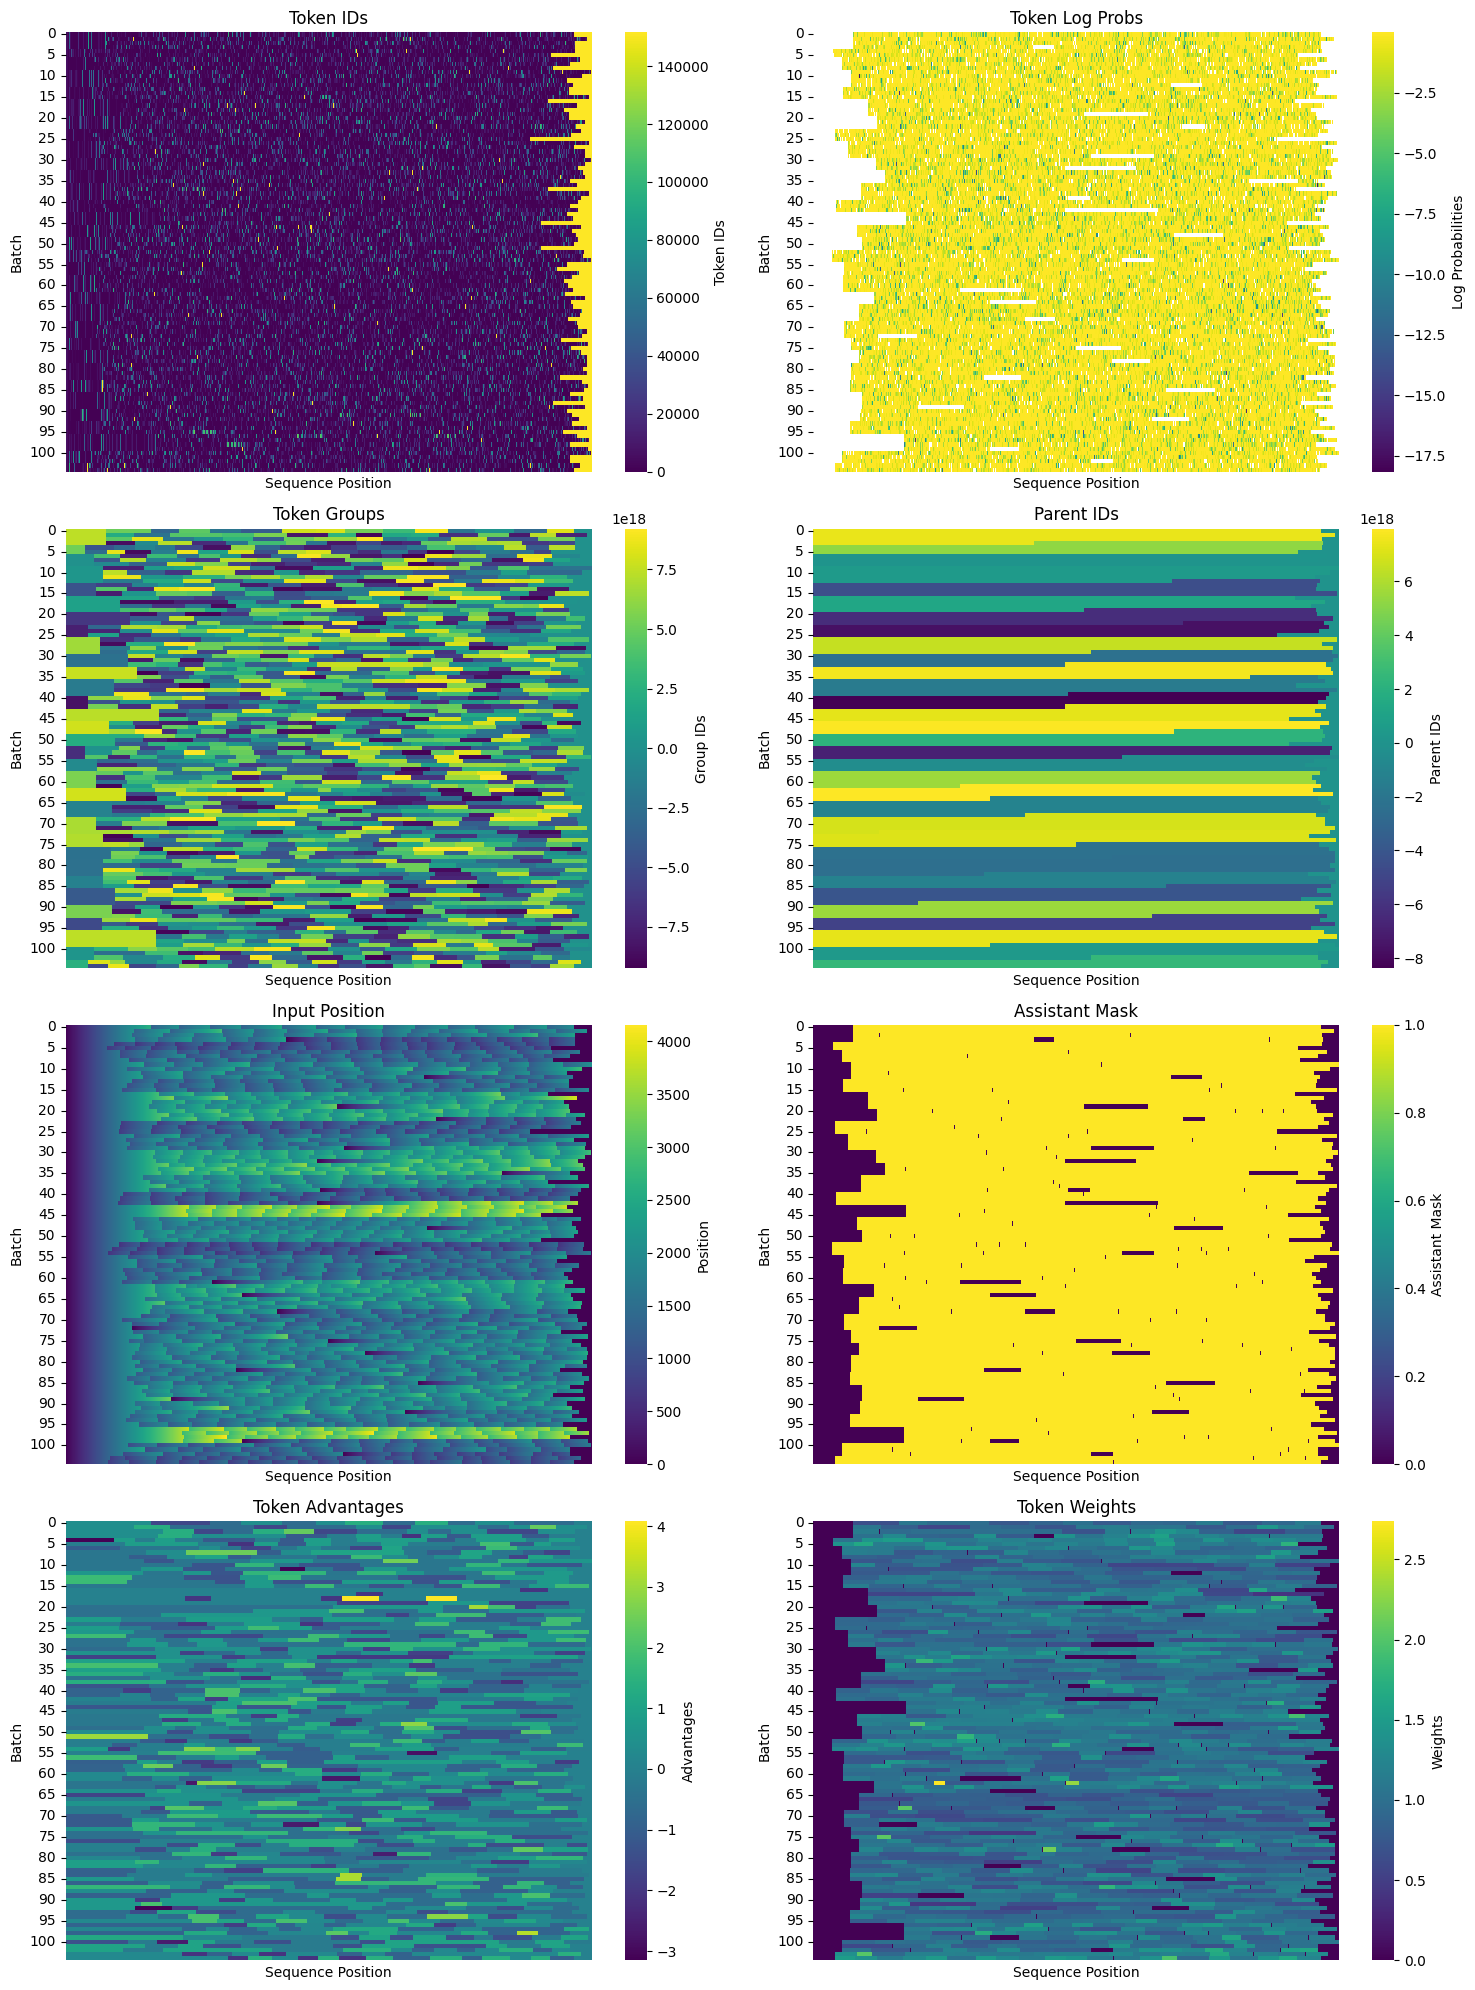

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 03:22:16.000000 102630 torch/distributed/run.py:793] 
W0223 03:22:16.000000 102630 torch/distributed/run.py:793] *****************************************
W0223 03:22:16.000000 102630 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 03:22:16.000000 102630 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0007
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-0

Writing logs to models/039/logs/log_1740280941.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.62 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|26|Loss: 0.0003: 100%|██████████| 26/26 [14:30<00:00, 32.63s/it, entropy=0.627, kl_div=nan, loss=0.000255, policy=0.000255]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0008 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0008 --port=8000 --api-key=default
INFO 02-23 03:38:31 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 03:38:32 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 03:38:32 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0008', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.50it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.50it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.51it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.08it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.07it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.86it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.72it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.65it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.72it/s]



(VllmWorkerProcess pid=113147) INFO 02-23 03:38:54 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 03:38:54 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=113147) INFO 02-23 03:38:57 worker.py:267] Memory profiling takes 3.28 seconds
(VllmWorkerProcess pid=113147) INFO 02-23 03:38:57 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=113147) INFO 02-23 03:38:57 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 03:38:57 worker.py:267] Memory profiling takes 3.40 seconds
INFO 02-23 03:38:57 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 03:38:57 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [111263]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 03:39:50 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-23 03:39:50 metrics.py:455] Avg prompt throughput: 5.3 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-23 03:39:50 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:38860 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:19<00:00,  1.94s/it, completion_tokens=872, prompt_tokens=1214, reward=0.343, acc=0.343, early_stop=0.00313, token_logprobs=1394569]
Deleted iteration directory ./models/039/0007


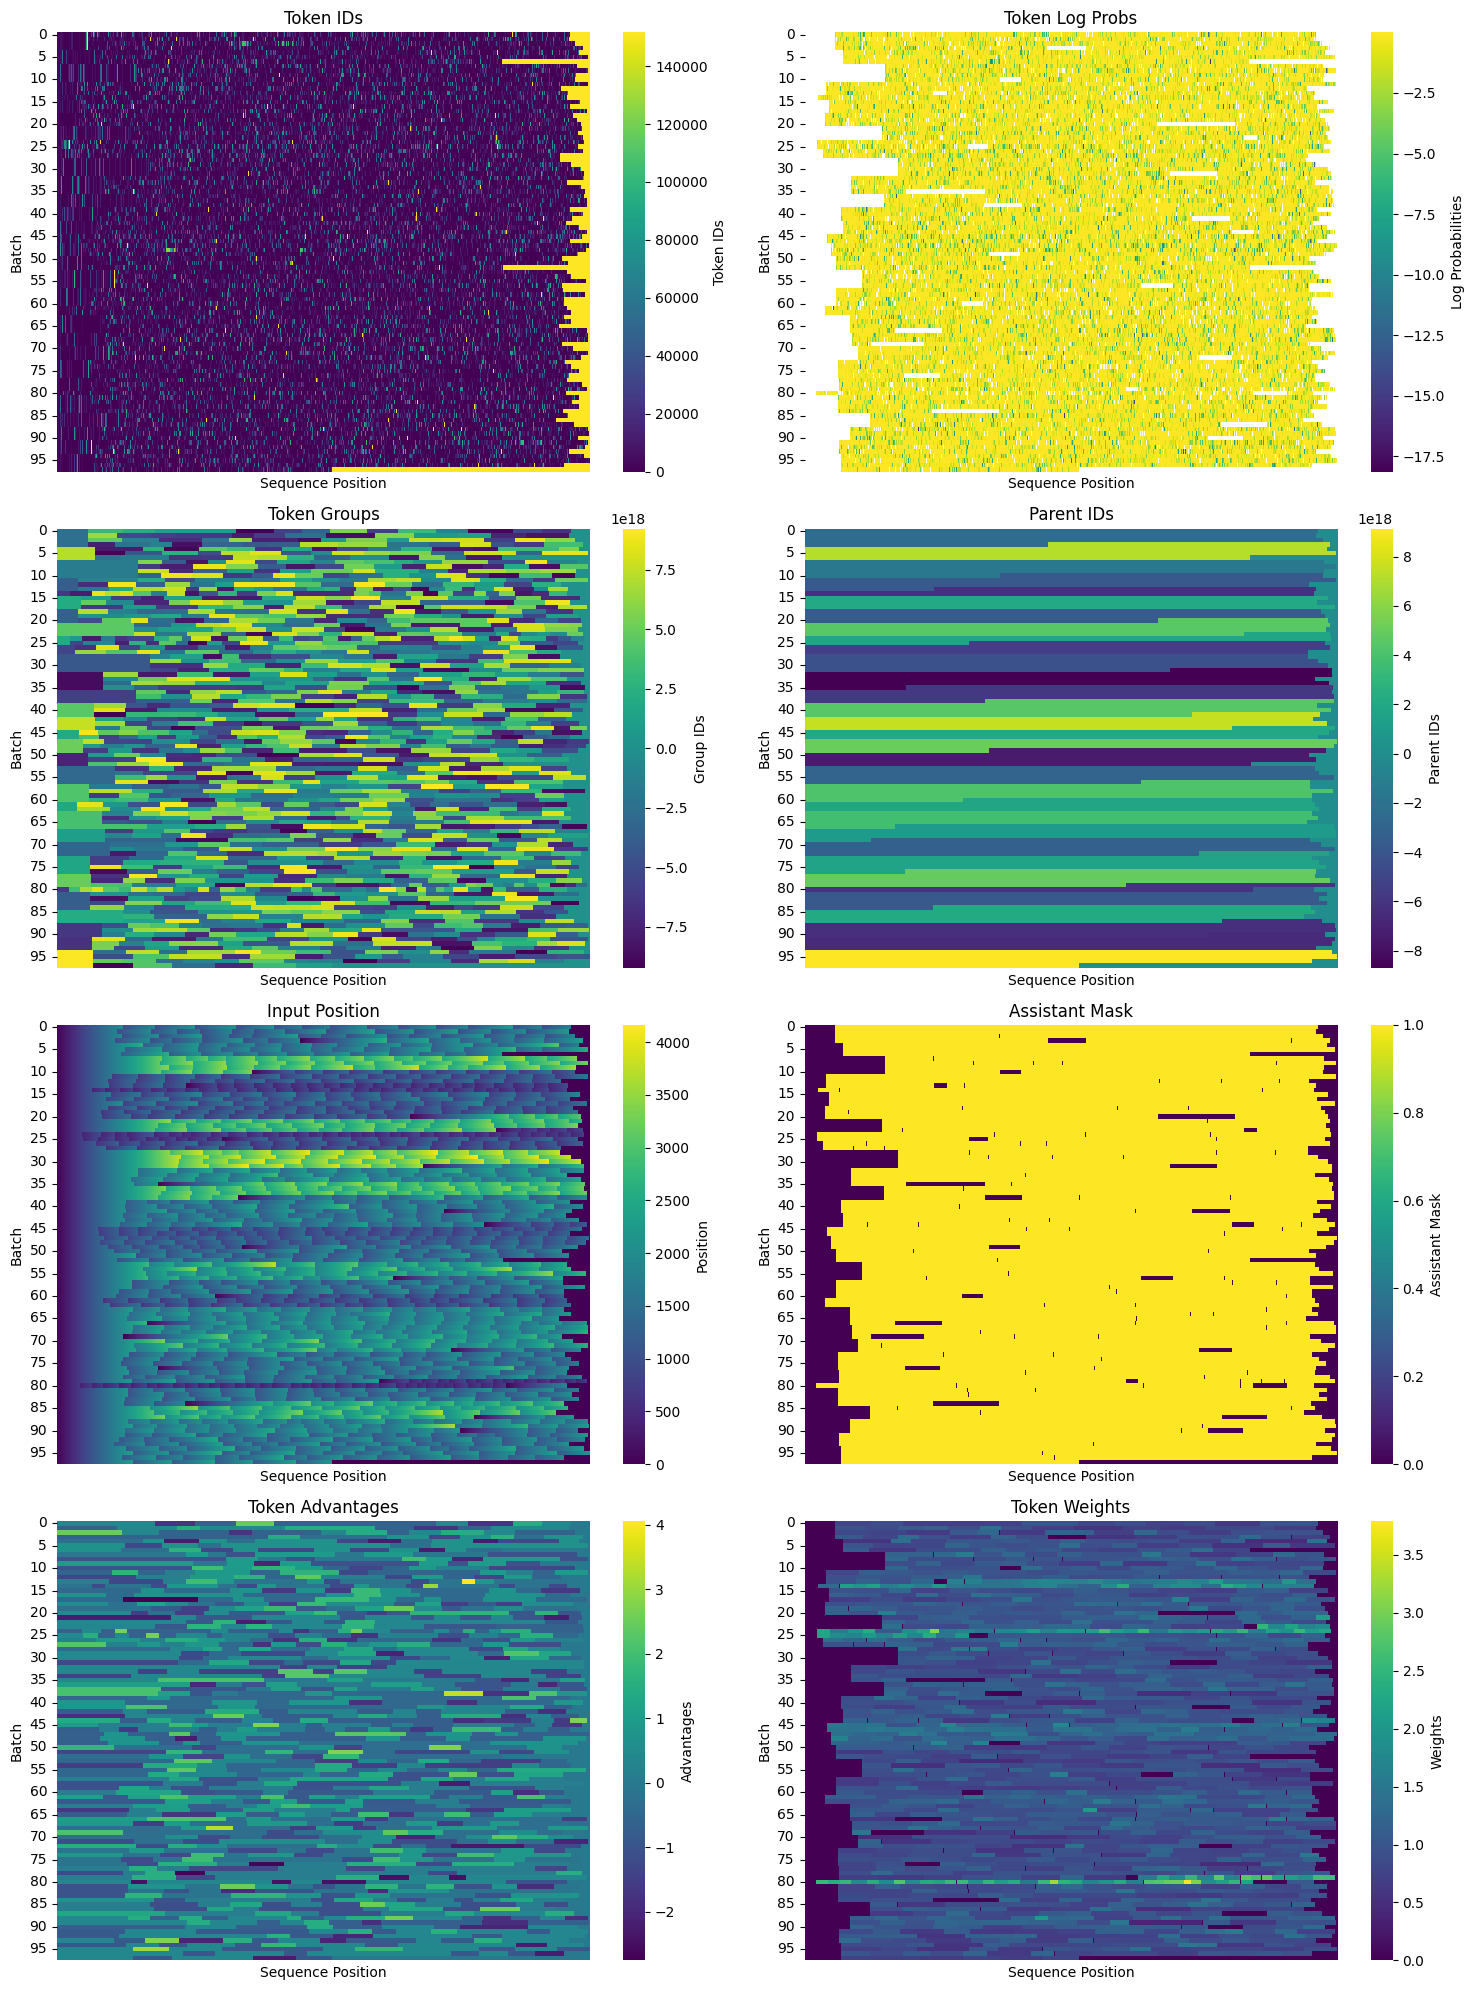

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 03:44:41.717000 116010 torch/distributed/run.py:793] 
W0223 03:44:41.717000 116010 torch/distributed/run.py:793] *****************************************
W0223 03:44:41.717000 116010 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 03:44:41.717000 116010 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0008
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008

Writing logs to models/039/logs/log_1740282286.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.95 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|24|Loss: -0.0000: 100%|██████████| 24/24 [13:25<00:00, 32.67s/it, entropy=0.607, kl_div=nan, loss=-2.7e-5, policy=-2.7e-5]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0009 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0009 --port=8000 --api-key=default
INFO 02-23 03:59:51 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 03:59:52 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 03:59:52 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0009', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.53it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.55it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.55it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.12it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.08it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.87it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.75it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.69it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.75it/s]



INFO 02-23 04:00:14 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=125731) INFO 02-23 04:00:14 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=125731) INFO 02-23 04:00:17 worker.py:267] Memory profiling takes 3.25 seconds
(VllmWorkerProcess pid=125731) INFO 02-23 04:00:17 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=125731) INFO 02-23 04:00:17 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 04:00:17 worker.py:267] Memory profiling takes 3.26 seconds
INFO 02-23 04:00:17 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 04:00:17 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [123830]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 04:01:09 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-23 04:01:09 metrics.py:455] Avg prompt throughput: 5.8 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-23 04:01:09 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:57434 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:41<00:00,  1.36it/s, completion_tokens=913, prompt_tokens=1324, reward=0.357, acc=0.357, early_stop=0.00187, token_logprobs=1460479]
Deleted iteration directory ./models/039/0006


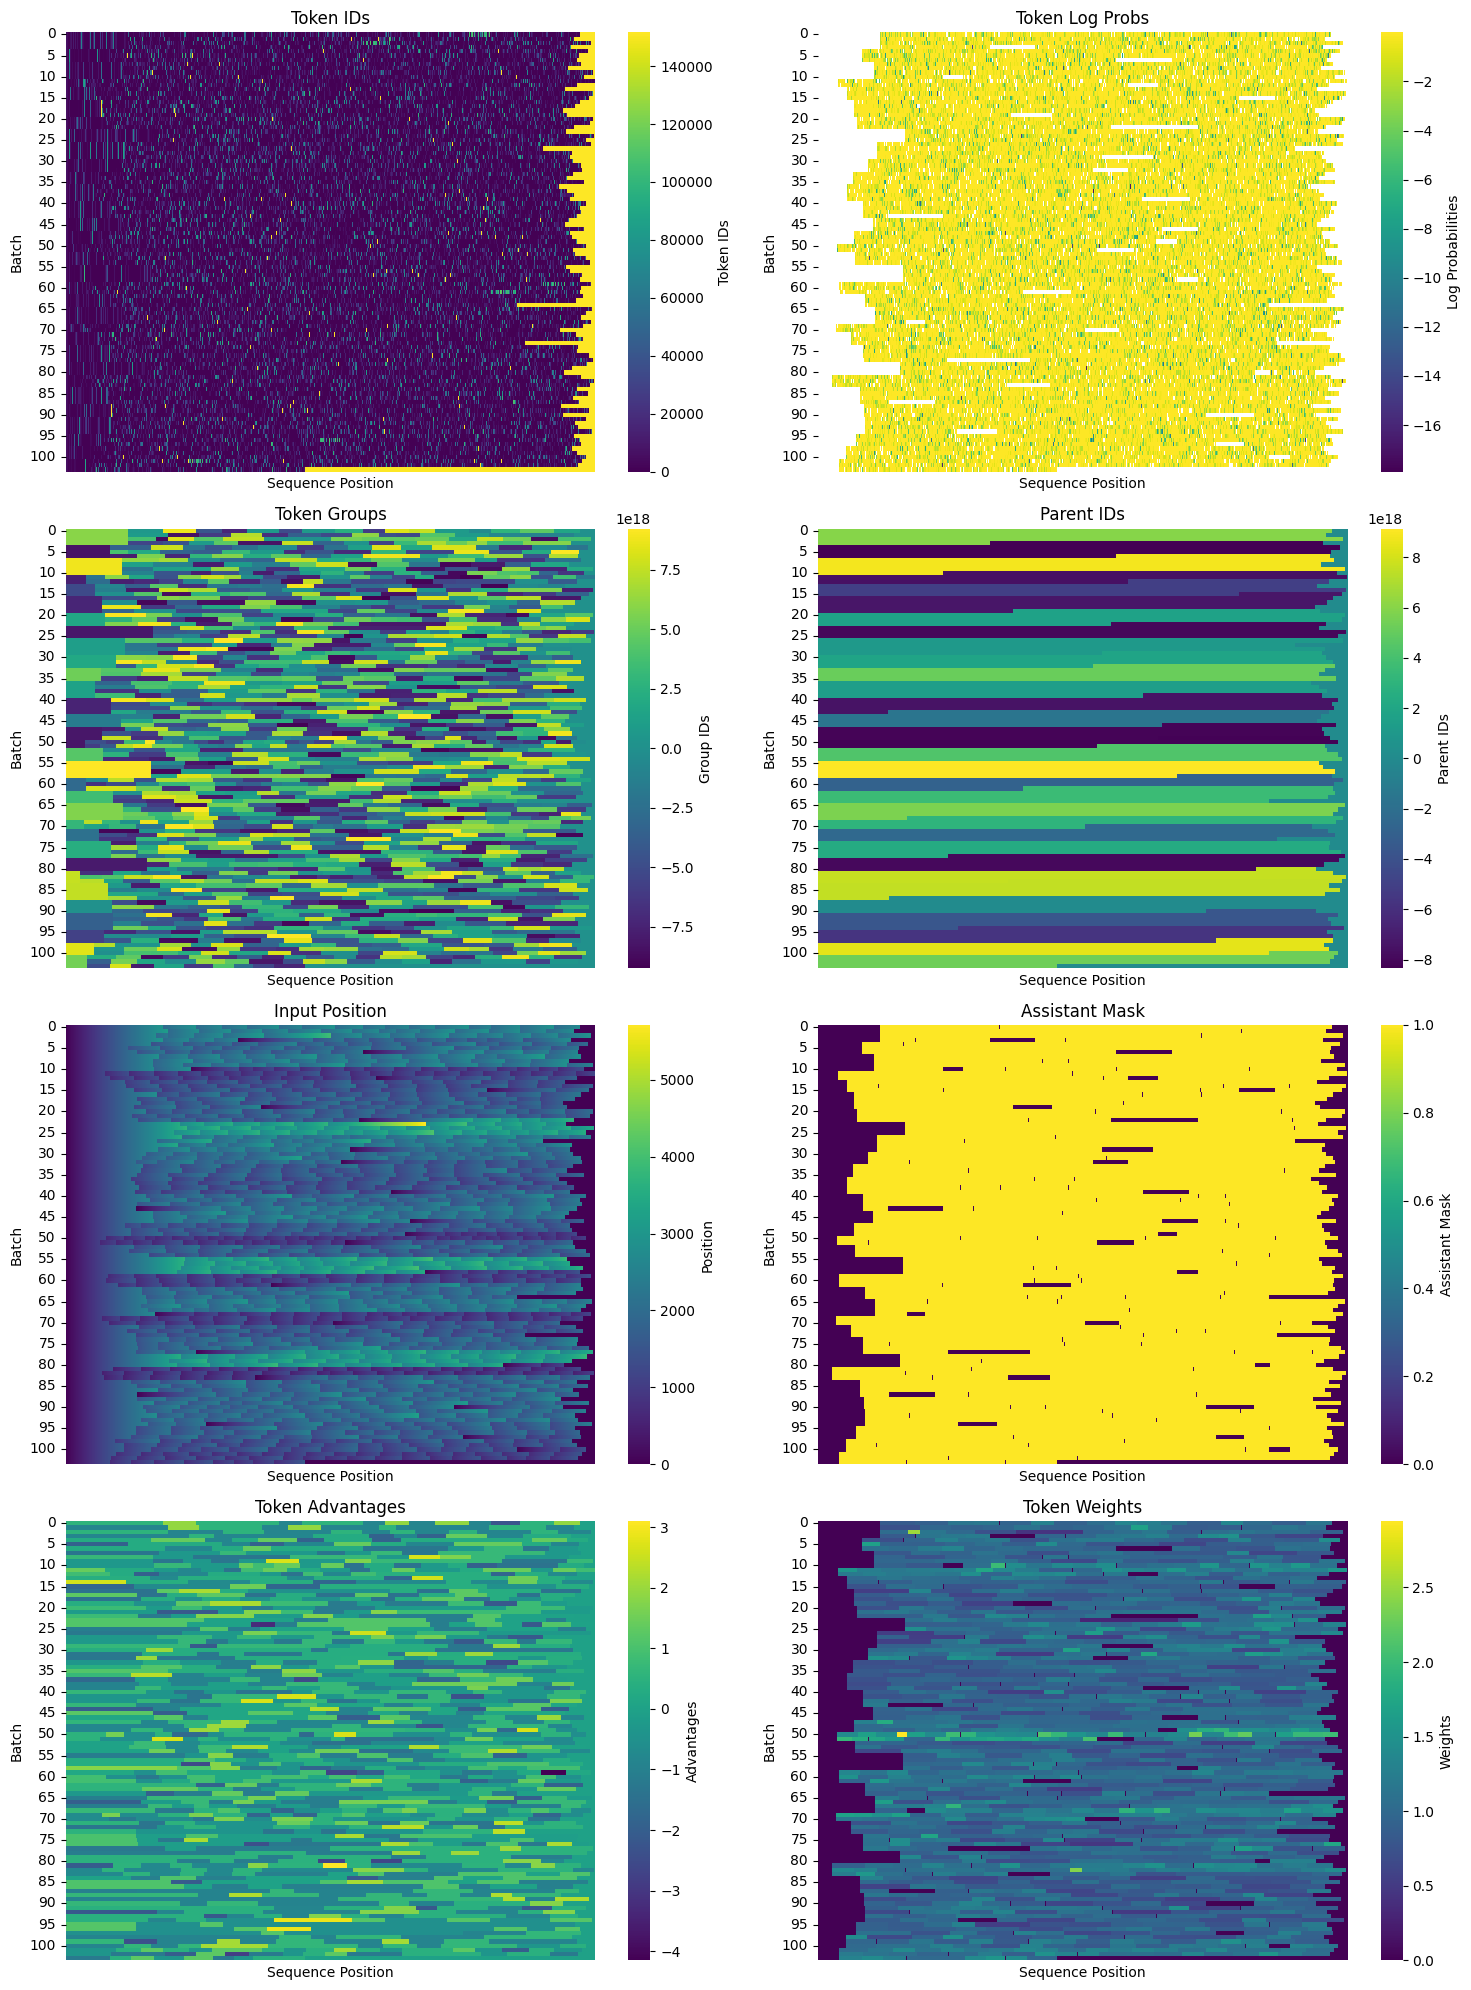

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 04:06:24.111000 128819 torch/distributed/run.py:793] 
W0223 04:06:24.111000 128819 torch/distributed/run.py:793] *****************************************
W0223 04:06:24.111000 128819 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 04:06:24.111000 128819 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0009
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008

Writing logs to models/039/logs/log_1740283589.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.72 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|26|Loss: -0.0001: 100%|██████████| 26/26 [14:31<00:00, 32.59s/it, entropy=0.555, kl_div=nan, loss=-0.000122, policy=-0.000122]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0010 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0010 --port=8000 --api-key=default
INFO 02-23 04:22:40 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 04:22:41 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 04:22:41 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0010', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.47it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.48it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:02<00:03,  1.49it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.04it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.02it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.83it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.72it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.66it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.71it/s]



(VllmWorkerProcess pid=138968) INFO 02-23 04:23:02 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 04:23:02 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=138968) INFO 02-23 04:23:06 worker.py:267] Memory profiling takes 3.36 seconds
(VllmWorkerProcess pid=138968) INFO 02-23 04:23:06 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=138968) INFO 02-23 04:23:06 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 04:23:06 worker.py:267] Memory profiling takes 3.45 seconds
INFO 02-23 04:23:06 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 04:23:06 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [137083]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 04:23:58 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39392 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [05:05<00:00,  1.58s/it, completion_tokens=884, prompt_tokens=1399, reward=0.38, acc=0.38, early_stop=0.00125, token_logprobs=1414409]
Deleted iteration directory ./models/039/0008


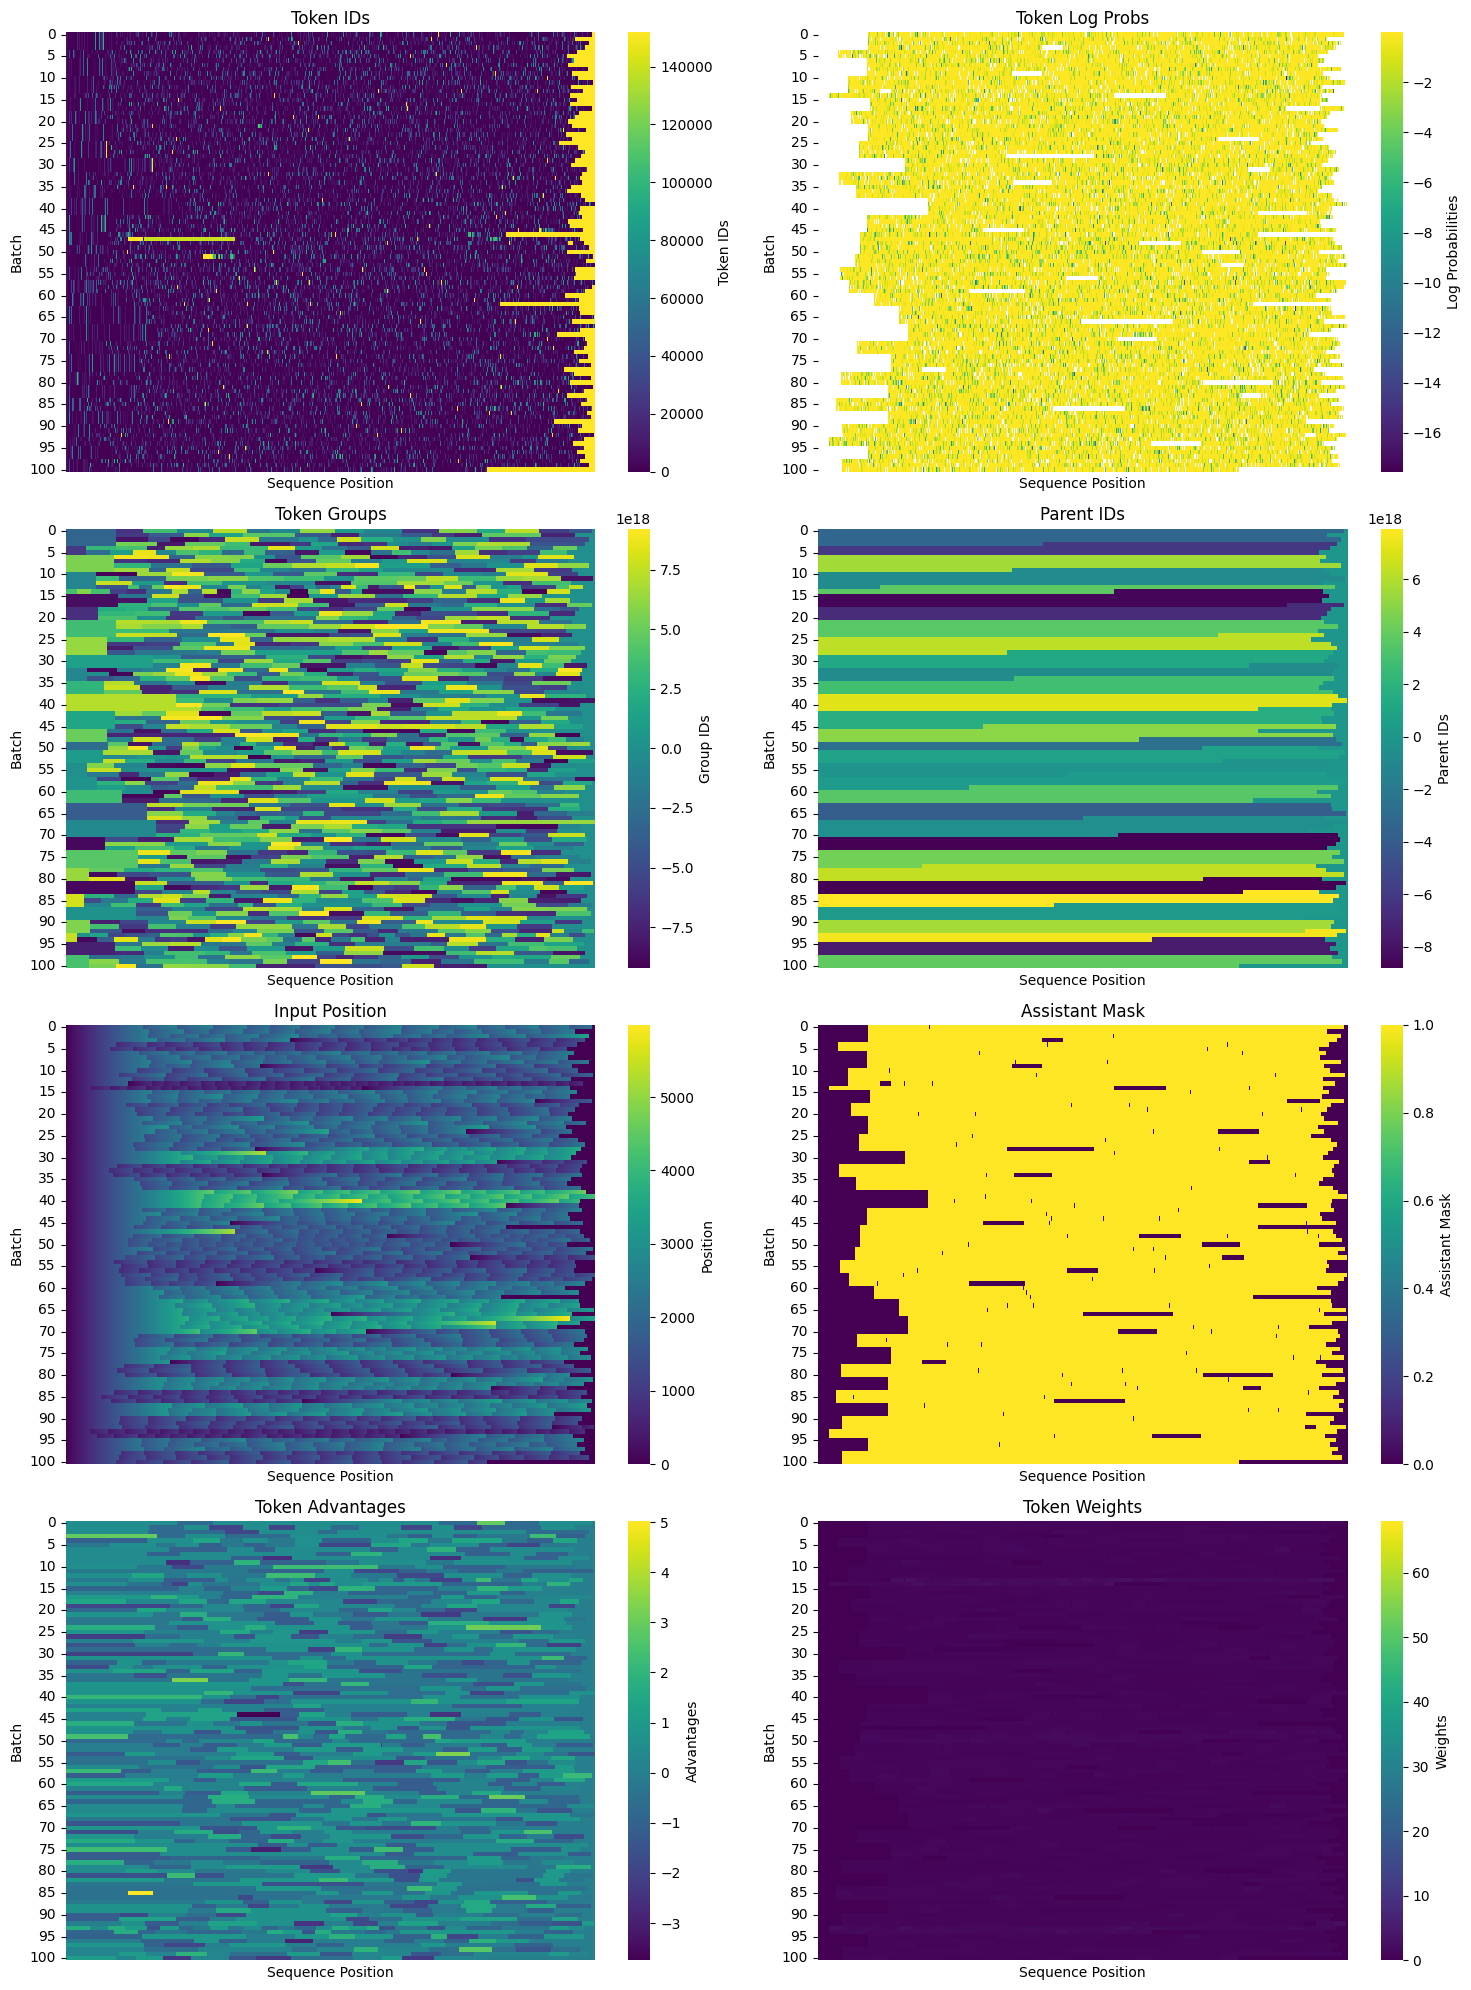

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 04:29:37.221000 142062 torch/distributed/run.py:793] 
W0223 04:29:37.221000 142062 torch/distributed/run.py:793] *****************************************
W0223 04:29:37.221000 142062 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 04:29:37.221000 142062 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0010
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-0

Writing logs to models/039/logs/log_1740284982.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.86 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|25|Loss: 0.0036: 100%|██████████| 25/25 [13:59<00:00, 32.70s/it, entropy=0.704, kl_div=nan, loss=0.00362, policy=0.00362]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0011 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0011 --port=8000 --api-key=default
INFO 02-23 04:45:21 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 04:45:22 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 04:45:22 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0011', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.46it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.49it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:02<00:03,  1.50it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.04it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.03it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.83it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.71it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.63it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.70it/s]



(VllmWorkerProcess pid=152522) INFO 02-23 04:45:44 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 04:45:44 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=152522) INFO 02-23 04:45:47 worker.py:267] Memory profiling takes 3.47 seconds
(VllmWorkerProcess pid=152522) INFO 02-23 04:45:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=152522) INFO 02-23 04:45:47 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 04:45:47 worker.py:267] Memory profiling takes 3.56 seconds
INFO 02-23 04:45:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 04:45:47 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [150632]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 04:46:39 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:54268 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:54<00:00,  1.66it/s, completion_tokens=912, prompt_tokens=1342, reward=0.4, acc=0.4, token_logprobs=1459361]
Deleted iteration directory ./models/039/0010


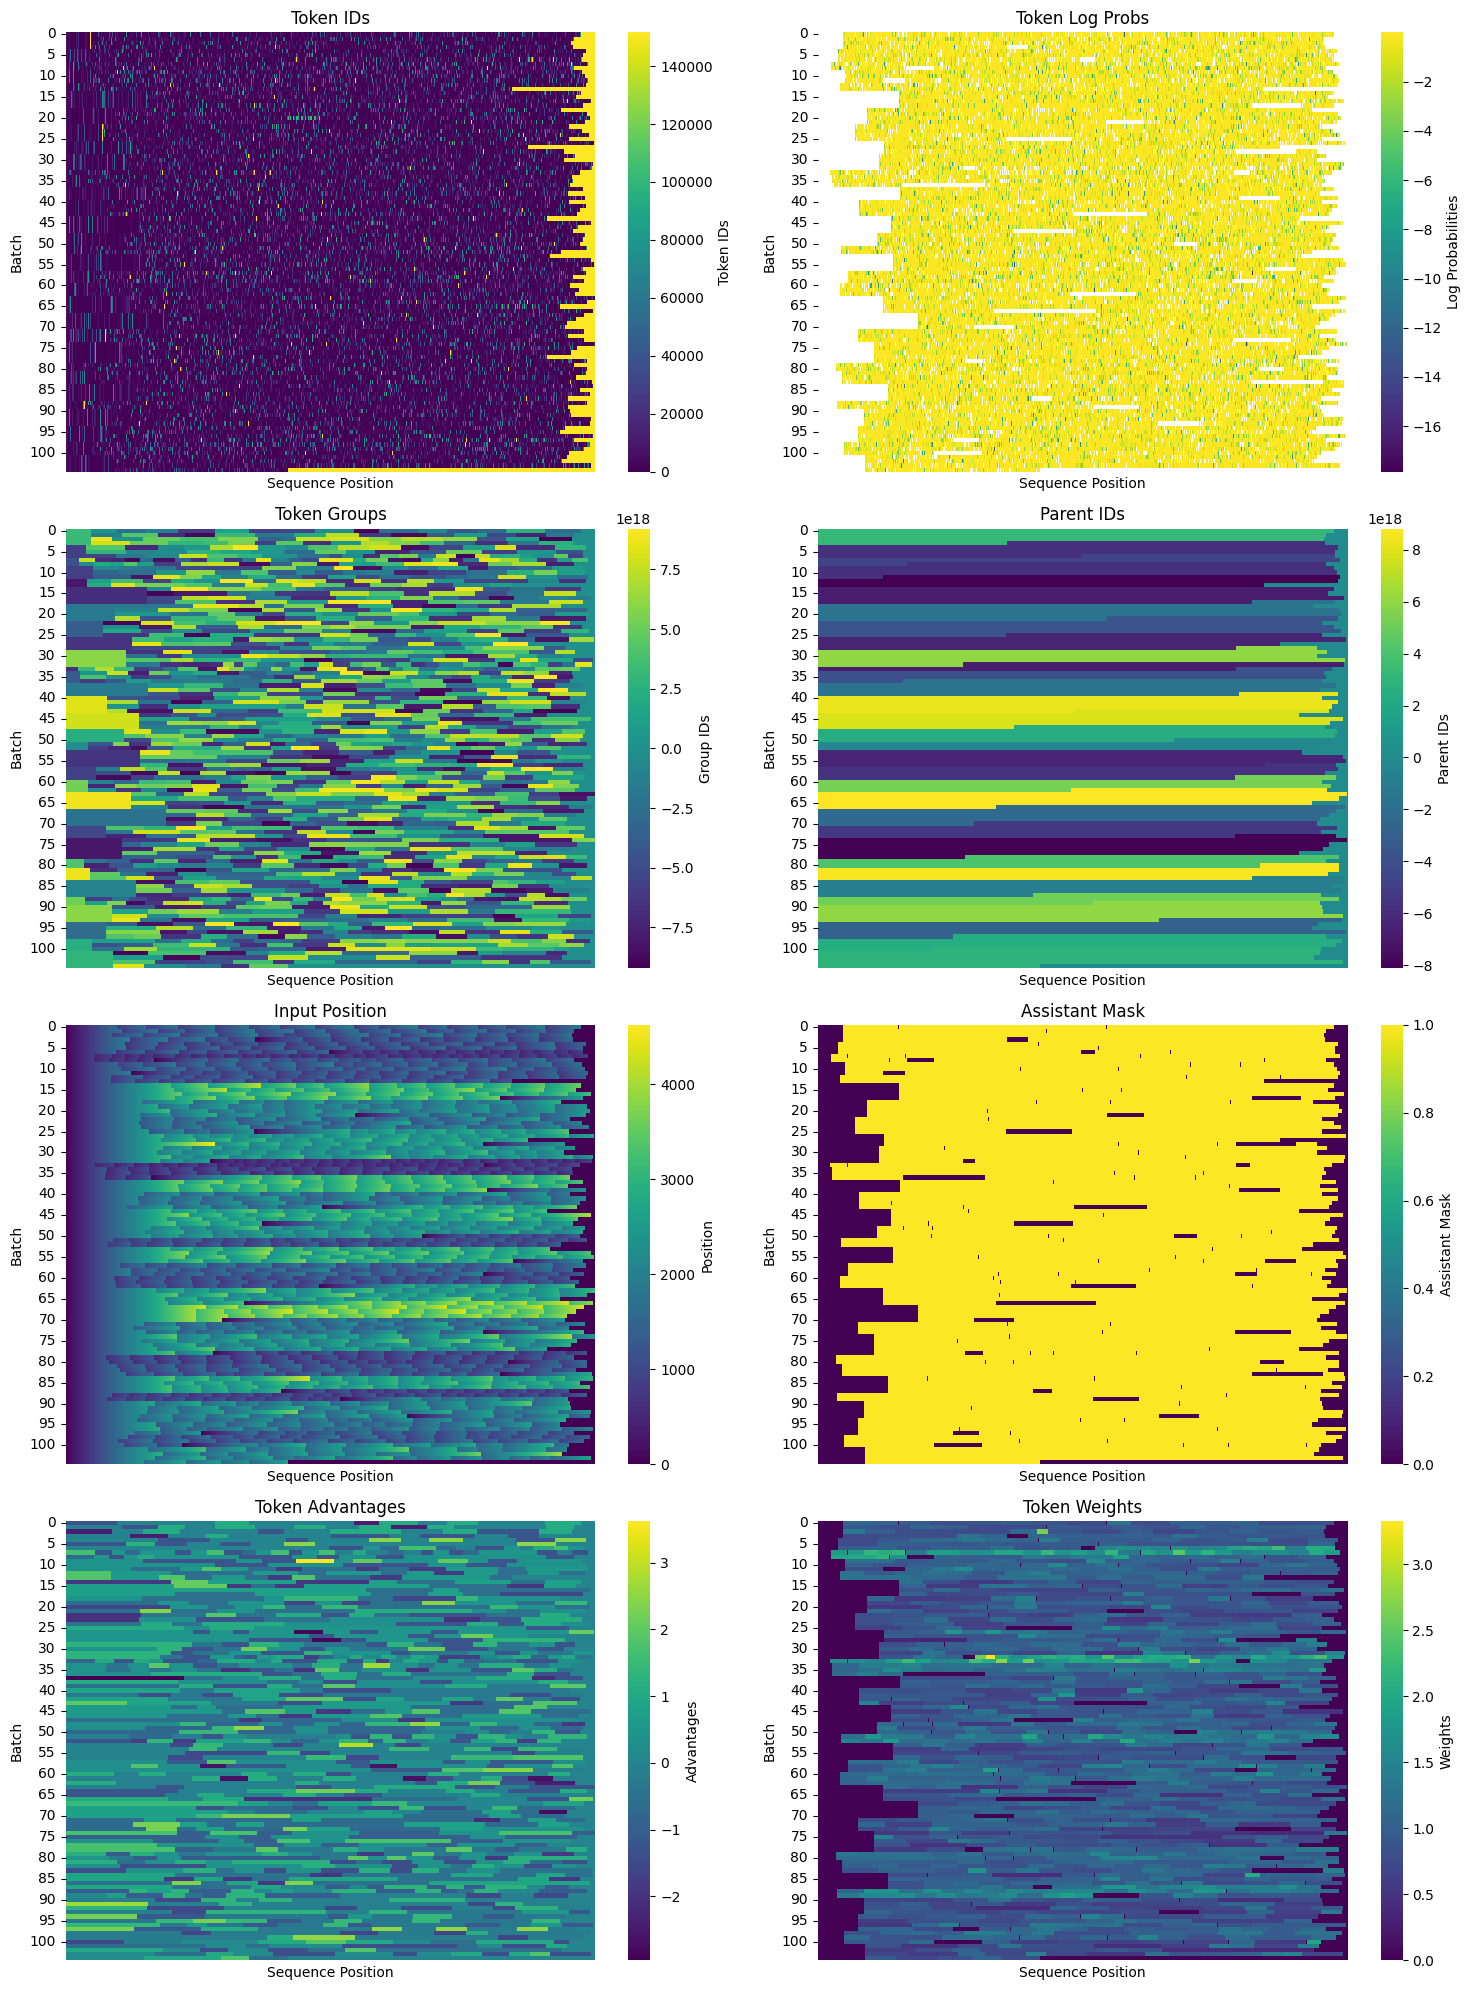

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 04:52:08.384000 155033 torch/distributed/run.py:793] 
W0223 04:52:08.384000 155033 torch/distributed/run.py:793] *****************************************
W0223 04:52:08.384000 155033 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 04:52:08.384000 155033 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0011
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-0

Writing logs to models/039/logs/log_1740286333.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.73 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|26|Loss: -0.0006: 100%|██████████| 26/26 [14:32<00:00, 32.68s/it, entropy=0.415, kl_div=nan, loss=-0.00062, policy=-0.00062]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0012 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0012 --port=8000 --api-key=default
INFO 02-23 05:08:25 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 05:08:26 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 05:08:26 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0012', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.48it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.52it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.11it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.07it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.86it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.74it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.67it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.74it/s]



INFO 02-23 05:08:47 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=165472) INFO 02-23 05:08:47 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=165472) INFO 02-23 05:08:51 worker.py:267] Memory profiling takes 3.76 seconds
(VllmWorkerProcess pid=165472) INFO 02-23 05:08:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=165472) INFO 02-23 05:08:51 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 05:08:51 worker.py:267] Memory profiling takes 3.85 seconds
INFO 02-23 05:08:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 05:08:51 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [163600]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 05:09:43 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:41264 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [05:26<00:00,  5.38it/s, completion_tokens=1001, prompt_tokens=1431, reward=0.396, acc=0.396, token_logprobs=1.6e+6]
Deleted iteration directory ./models/039/0009


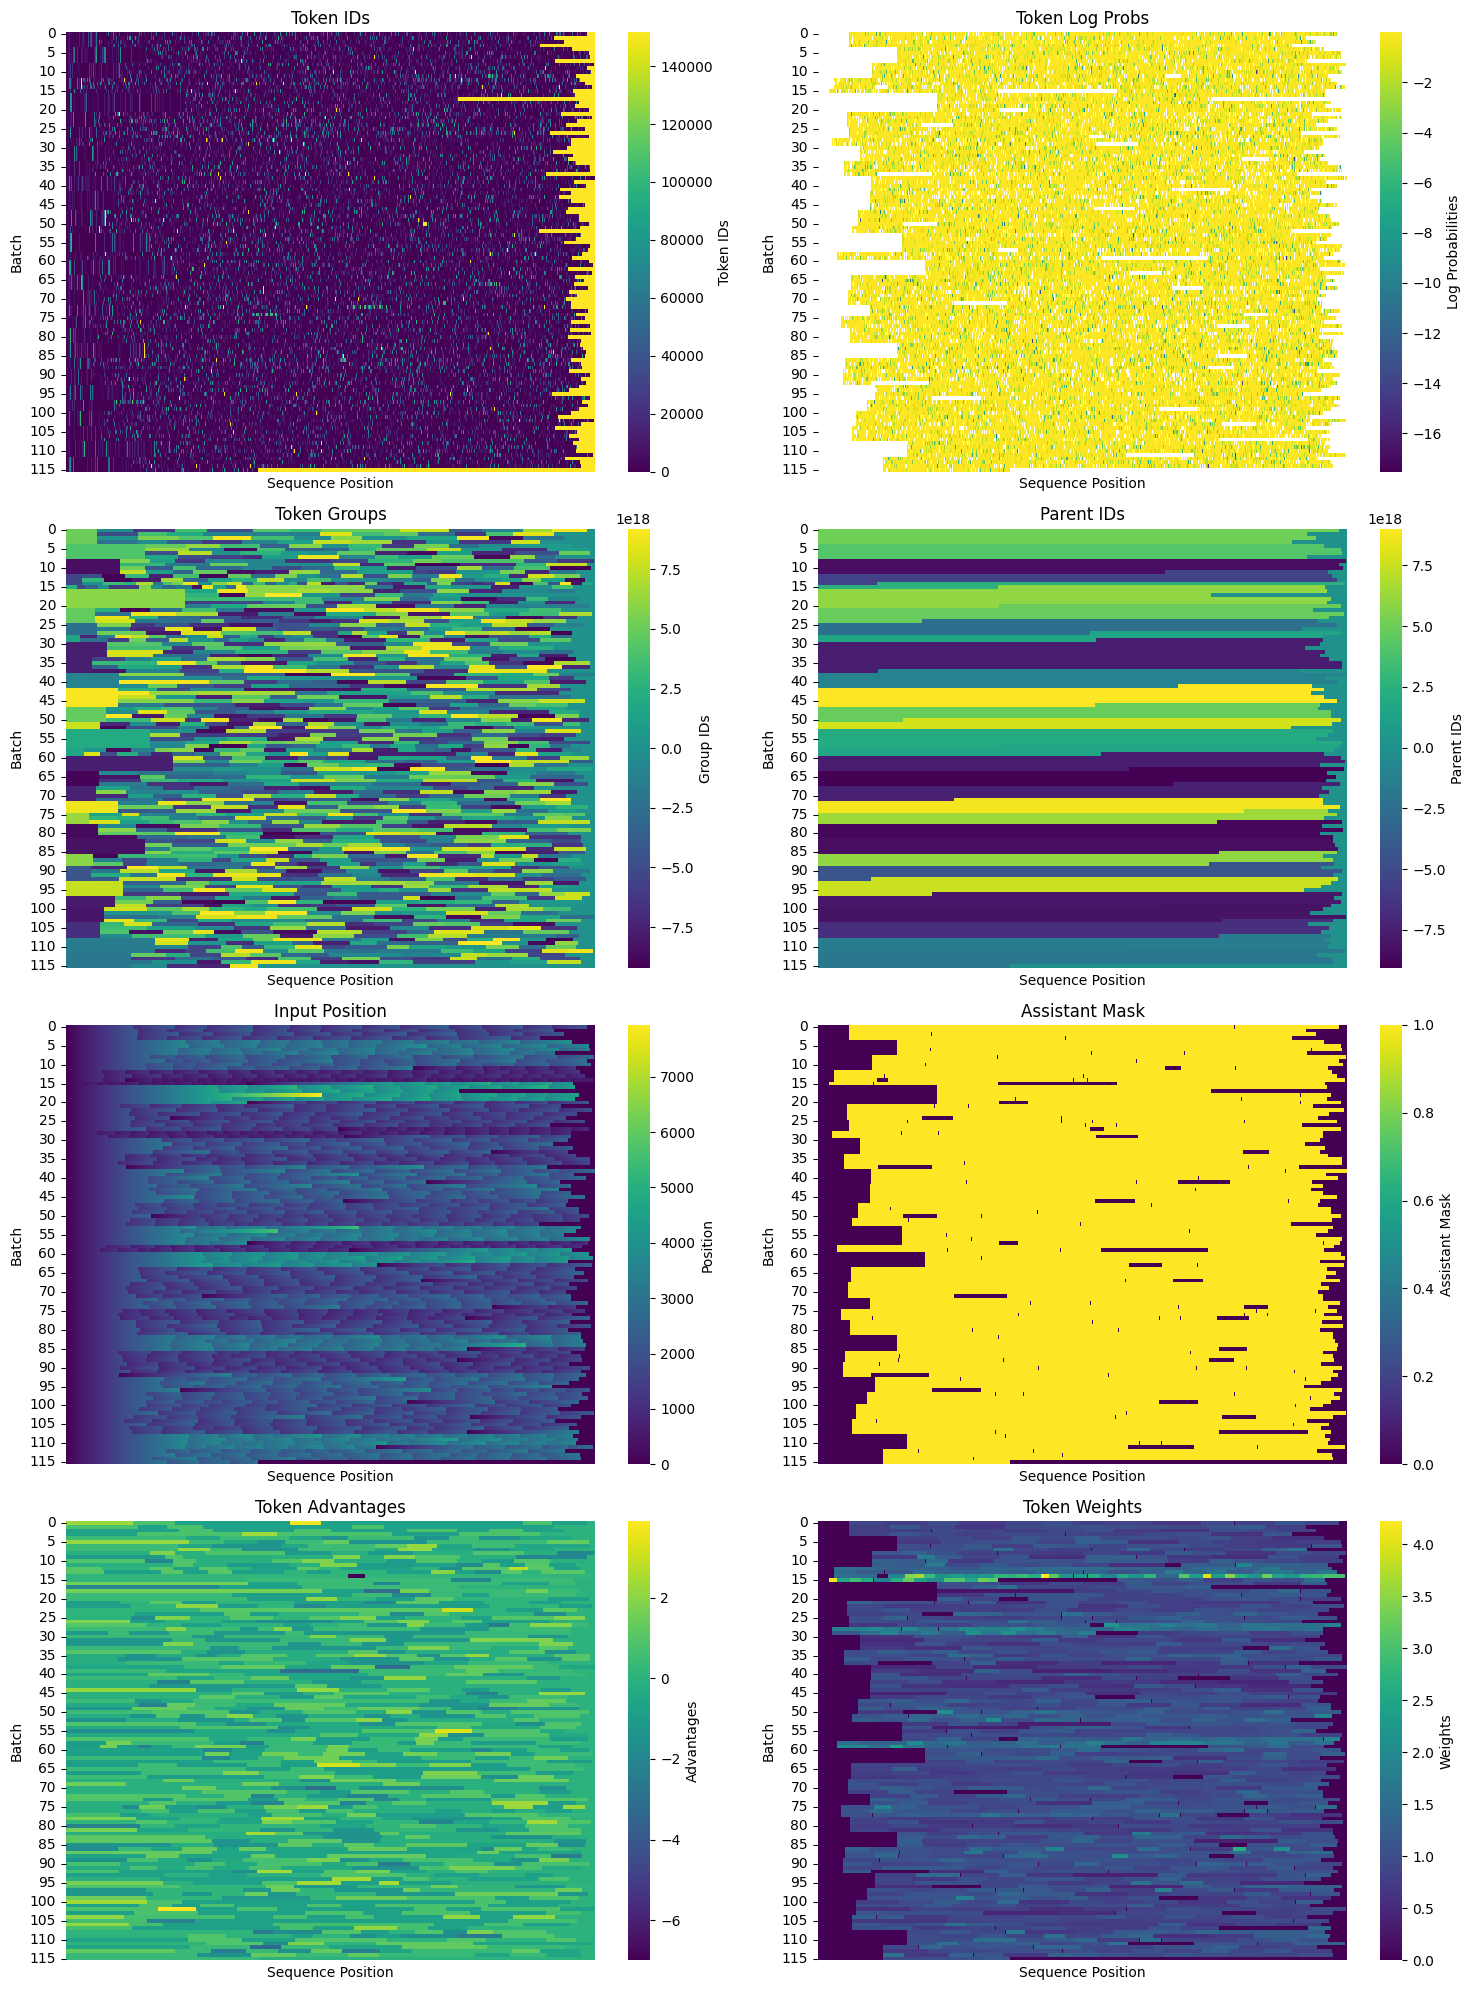

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 05:15:45.729000 168665 torch/distributed/run.py:793] 
W0223 05:15:45.729000 168665 torch/distributed/run.py:793] *****************************************
W0223 05:15:45.729000 168665 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 05:15:45.729000 168665 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0012
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008

Writing logs to models/039/logs/log_1740287751.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.87 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|29|Loss: 0.0006: 100%|██████████| 29/29 [16:09<00:00, 32.66s/it, entropy=0.418, kl_div=nan, loss=0.000608, policy=0.000608]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0013 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0013 --port=8000 --api-key=default
INFO 02-23 05:33:39 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 05:33:40 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 05:33:40 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0013', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.49it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.52it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.11it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.09it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.88it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.75it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.69it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.75it/s]



(VllmWorkerProcess pid=179390) INFO 02-23 05:34:03 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-23 05:34:03 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=179390) INFO 02-23 05:34:07 worker.py:267] Memory profiling takes 3.50 seconds
(VllmWorkerProcess pid=179390) INFO 02-23 05:34:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=179390) INFO 02-23 05:34:07 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 05:34:07 worker.py:267] Memory profiling takes 3.50 seconds
INFO 02-23 05:34:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 05:34:07 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [177497]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 05:35:02 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-23 05:35:03 metrics.py:455] Avg prompt throughput: 4.1 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-23 05:35:03 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:43504 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [05:10<00:00,  2.10s/it, completion_tokens=1029, prompt_tokens=1360, reward=0.413, acc=0.413, token_logprobs=1646714]
Deleted iteration directory ./models/039/0012


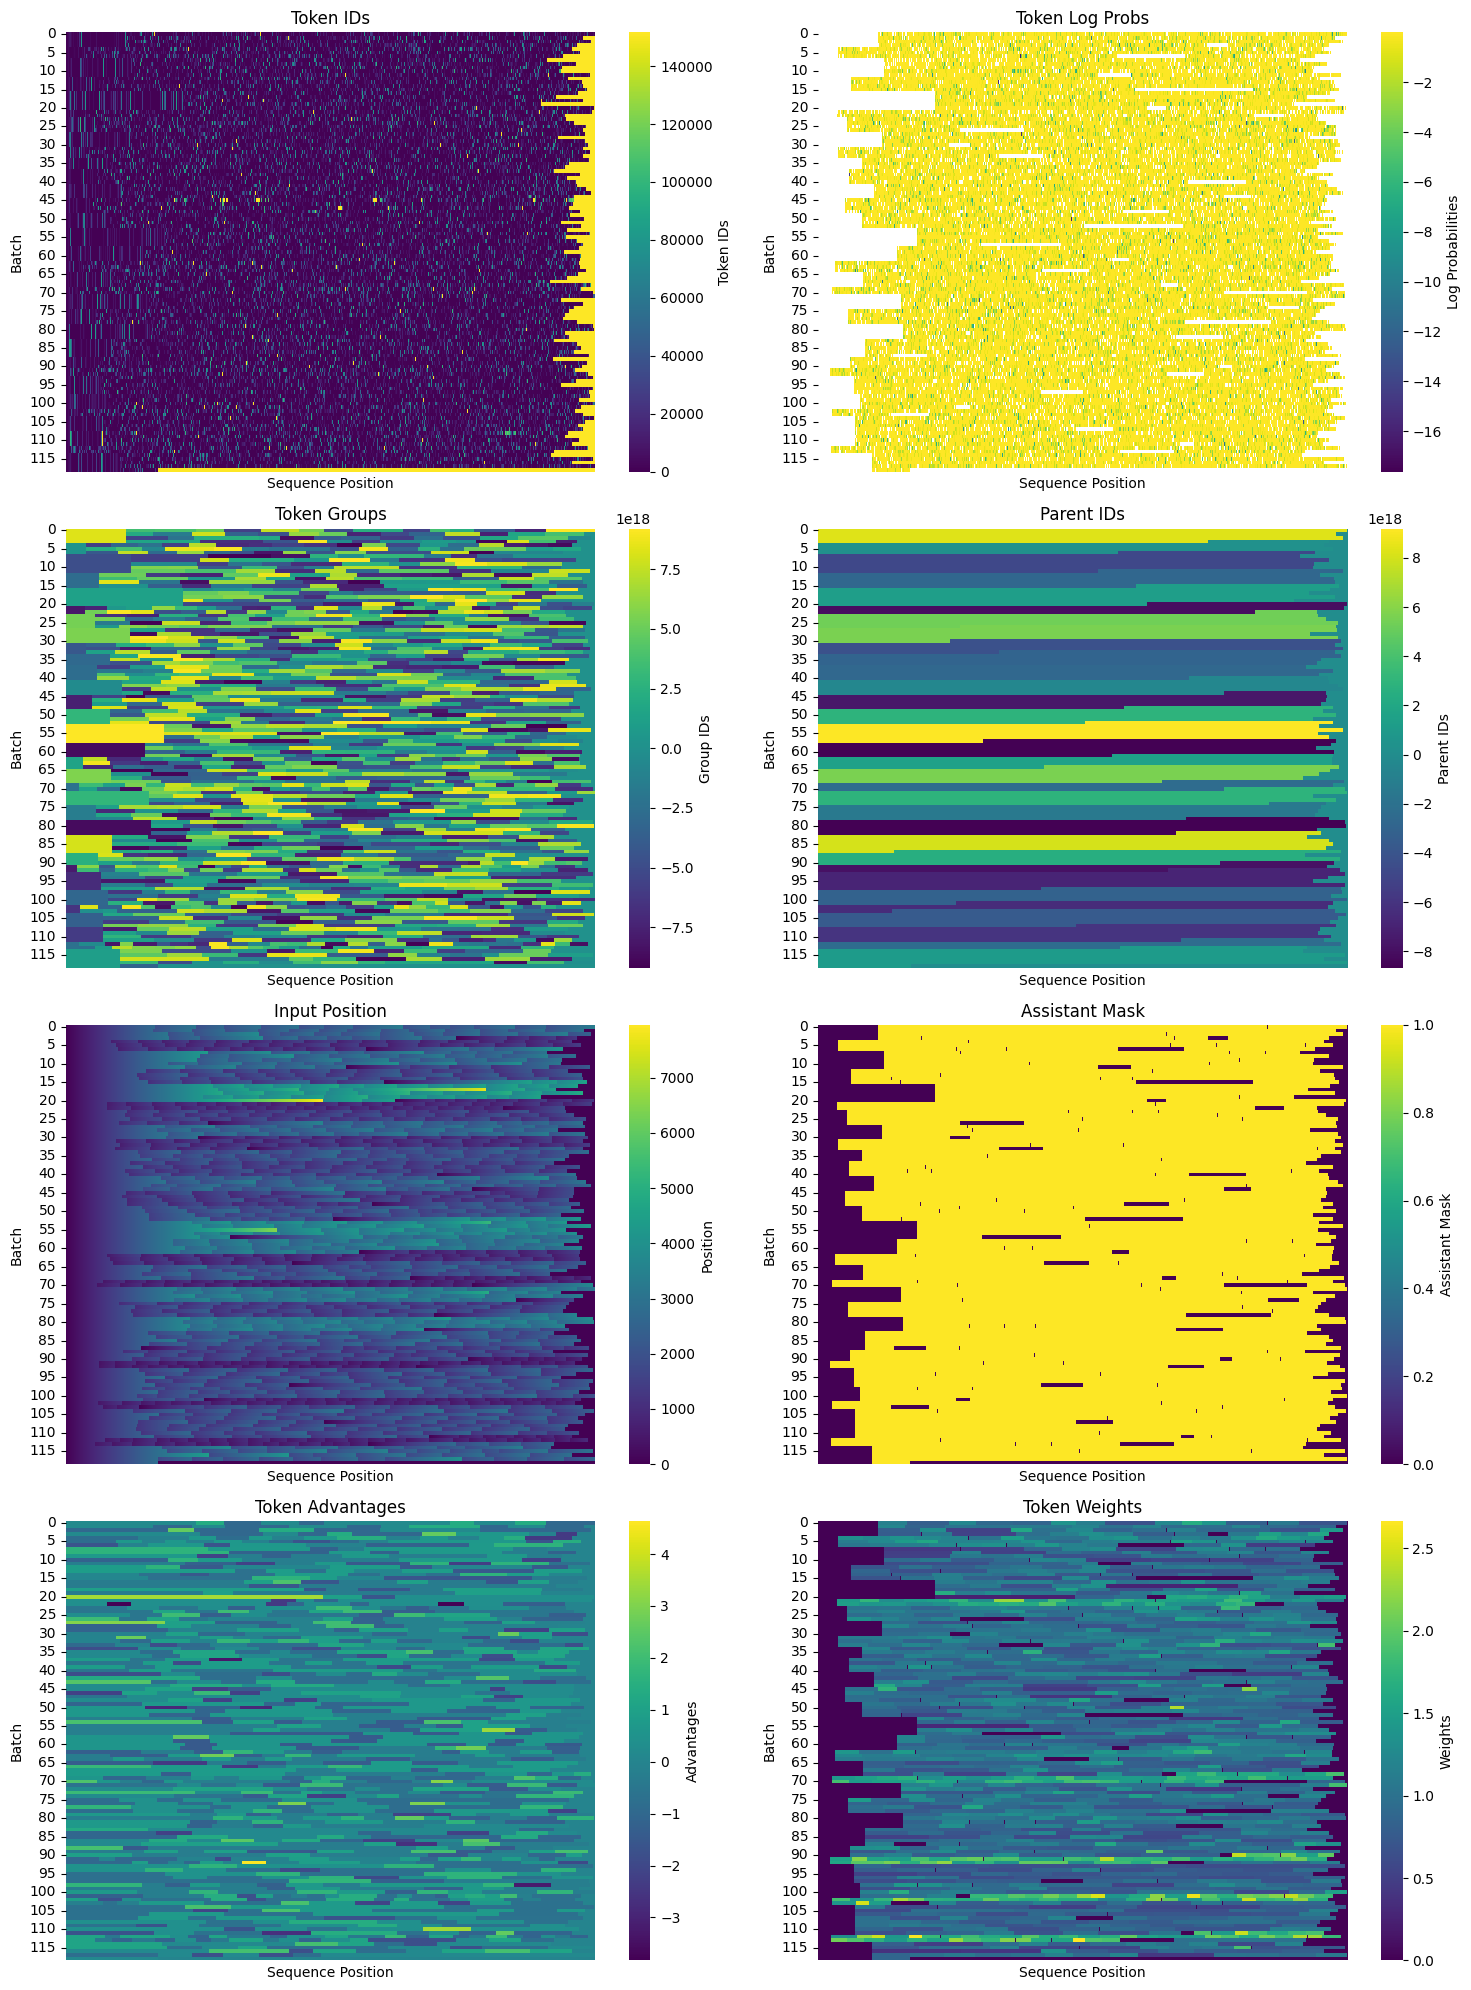

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 05:40:49.590000 182576 torch/distributed/run.py:793] 
W0223 05:40:49.590000 182576 torch/distributed/run.py:793] *****************************************
W0223 05:40:49.590000 182576 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 05:40:49.590000 182576 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0013
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008

Writing logs to models/039/logs/log_1740289254.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.62 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|30|Loss: -0.0002: 100%|██████████| 30/30 [16:42<00:00, 32.67s/it, entropy=0.372, kl_div=nan, loss=-0.000167, policy=-0.000167]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0014 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0014 --port=8000 --api-key=default
INFO 02-23 05:59:16 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 05:59:17 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 05:59:17 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0014', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.44it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.44it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:02<00:03,  1.45it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:02,  1.97it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  1.96it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.76it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.64it/s]


(VllmWorkerProcess pid=193903) INFO 02-23 05:59:38 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.59it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.64it/s]



INFO 02-23 05:59:39 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=193903) INFO 02-23 05:59:42 worker.py:267] Memory profiling takes 3.32 seconds
(VllmWorkerProcess pid=193903) INFO 02-23 05:59:42 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=193903) INFO 02-23 05:59:42 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 05:59:42 worker.py:267] Memory profiling takes 3.40 seconds
INFO 02-23 05:59:42 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 05:59:42 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [192016]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 06:00:36 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-23 06:00:37 metrics.py:455] Avg prompt throughput: 4.5 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-23 06:00:37 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:36286 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [04:39<00:00,  5.13it/s, completion_tokens=968, prompt_tokens=1097, reward=0.426, acc=0.426, token_logprobs=1548335]
Deleted iteration directory ./models/039/0013


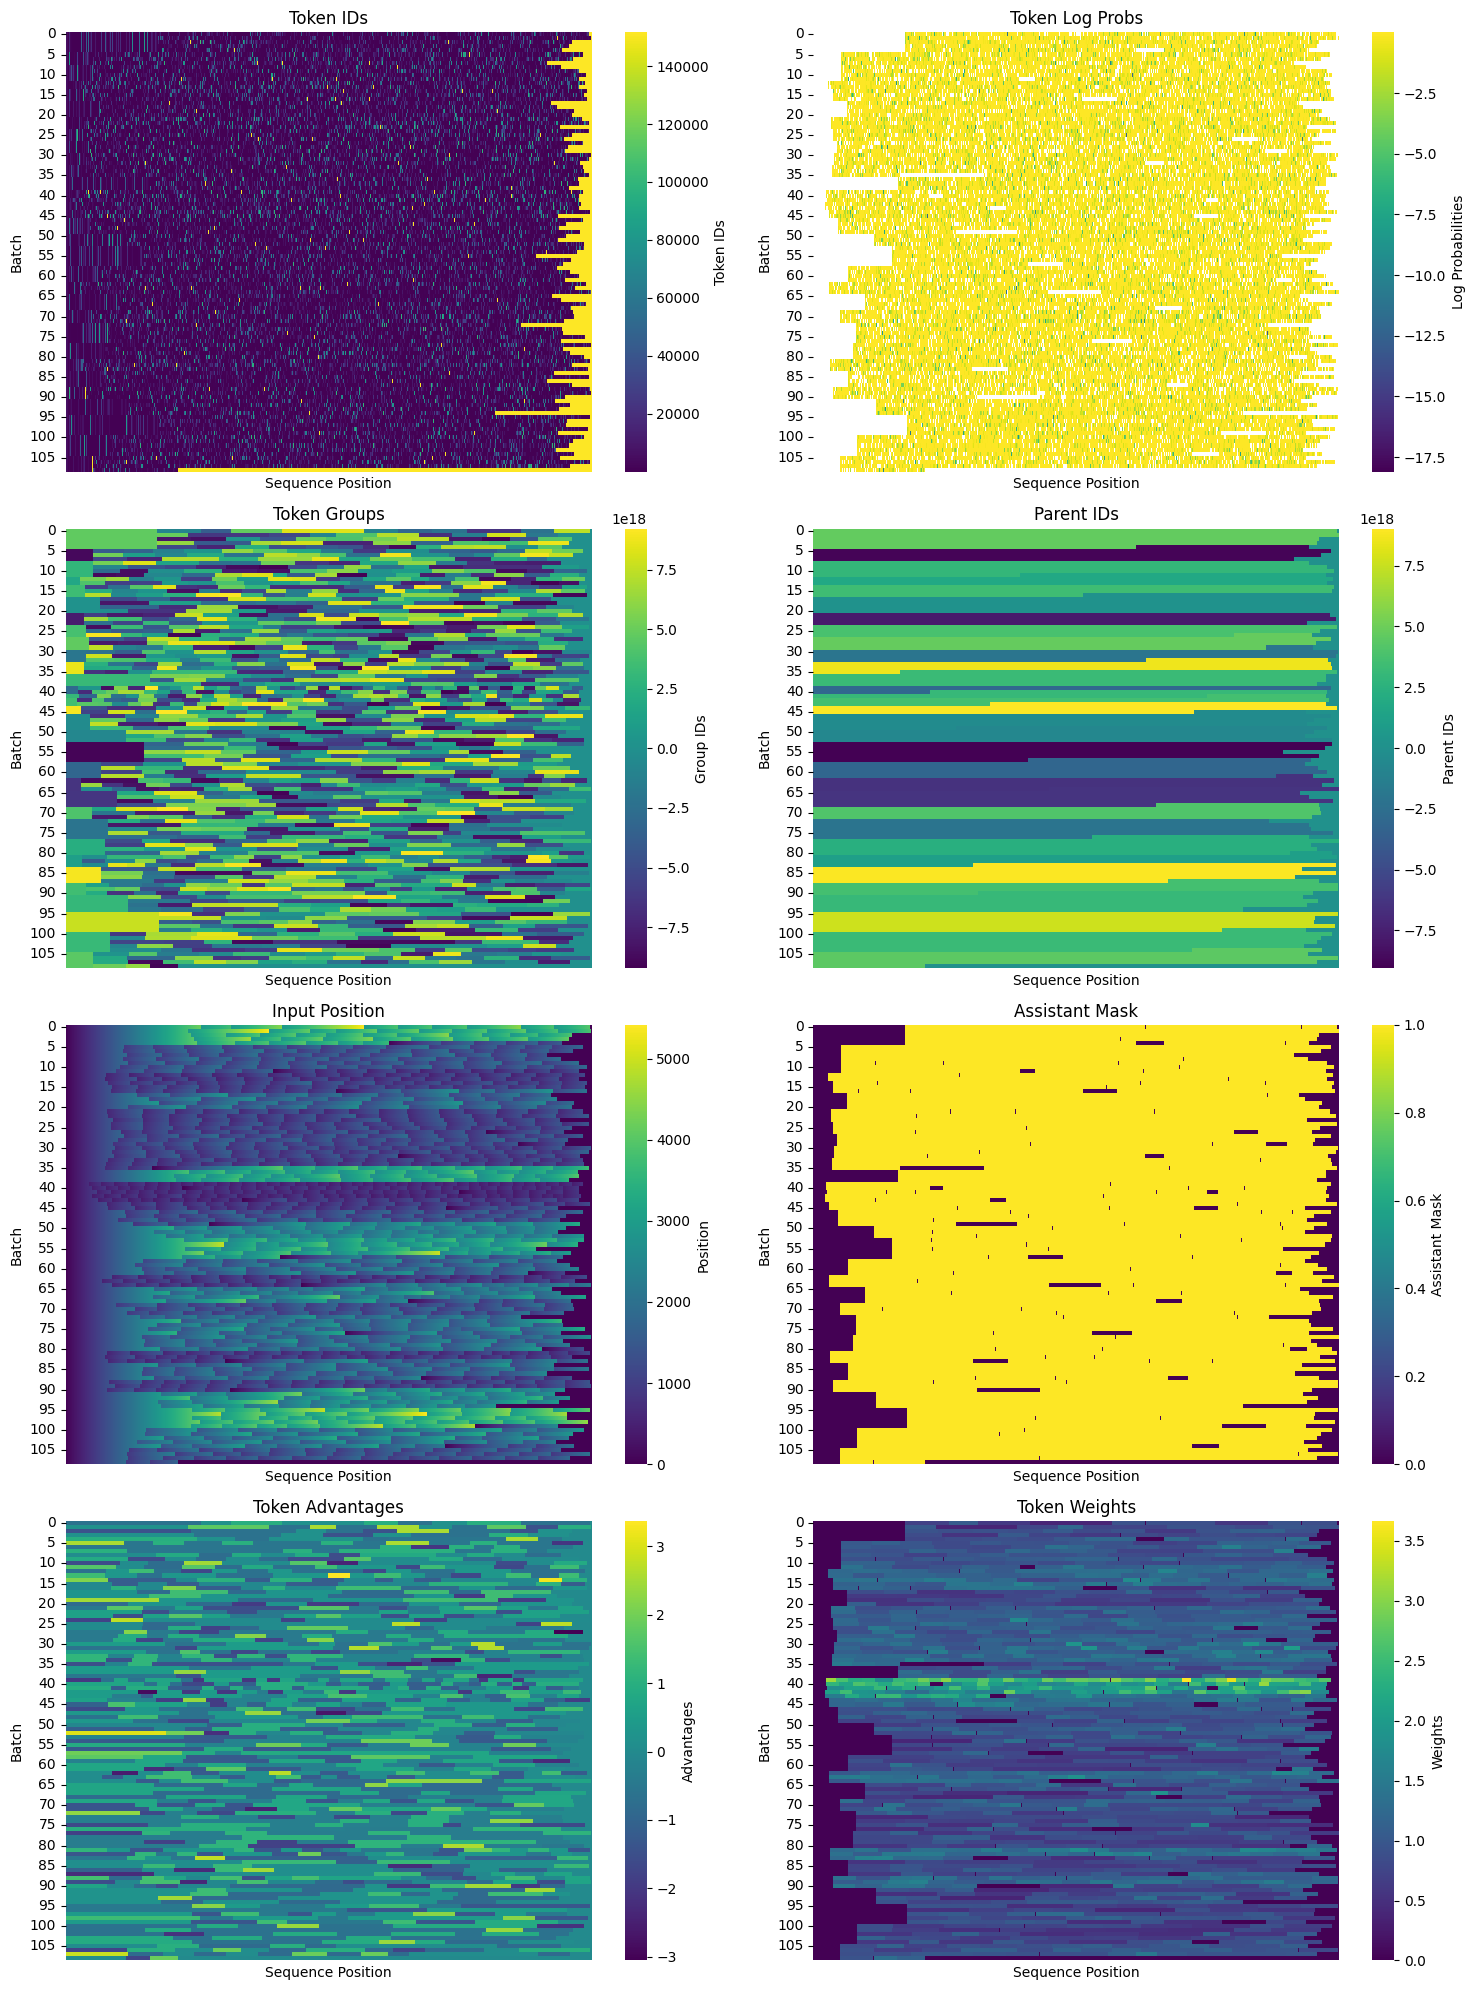

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 06:05:50.613000 196798 torch/distributed/run.py:793] 
W0223 06:05:50.613000 196798 torch/distributed/run.py:793] *****************************************
W0223 06:05:50.613000 196798 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 06:05:50.613000 196798 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0014
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008

Writing logs to models/039/logs/log_1740290756.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.48 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|27|Loss: 0.0002: 100%|██████████| 27/27 [15:03<00:00, 32.65s/it, entropy=0.324, kl_div=nan, loss=0.000181, policy=0.000181]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict..

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0015 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0015 --port=8000 --api-key=default
INFO 02-23 06:22:39 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 06:22:40 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 06:22:40 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0015', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.49it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.52it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.53it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.09it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.07it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.86it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.74it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.67it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.73it/s]



INFO 02-23 06:23:02 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=207139) INFO 02-23 06:23:02 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=207139) INFO 02-23 06:23:05 worker.py:267] Memory profiling takes 3.31 seconds
(VllmWorkerProcess pid=207139) INFO 02-23 06:23:05 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=207139) INFO 02-23 06:23:05 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 06:23:05 worker.py:267] Memory profiling takes 3.37 seconds
INFO 02-23 06:23:05 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 06:23:05 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [205246]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 06:23:58 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:37530 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [05:48<00:00,  3.34it/s, completion_tokens=1072, prompt_tokens=1556, reward=0.385, acc=0.385, token_logprobs=1715312]
Deleted iteration directory ./models/039/0014


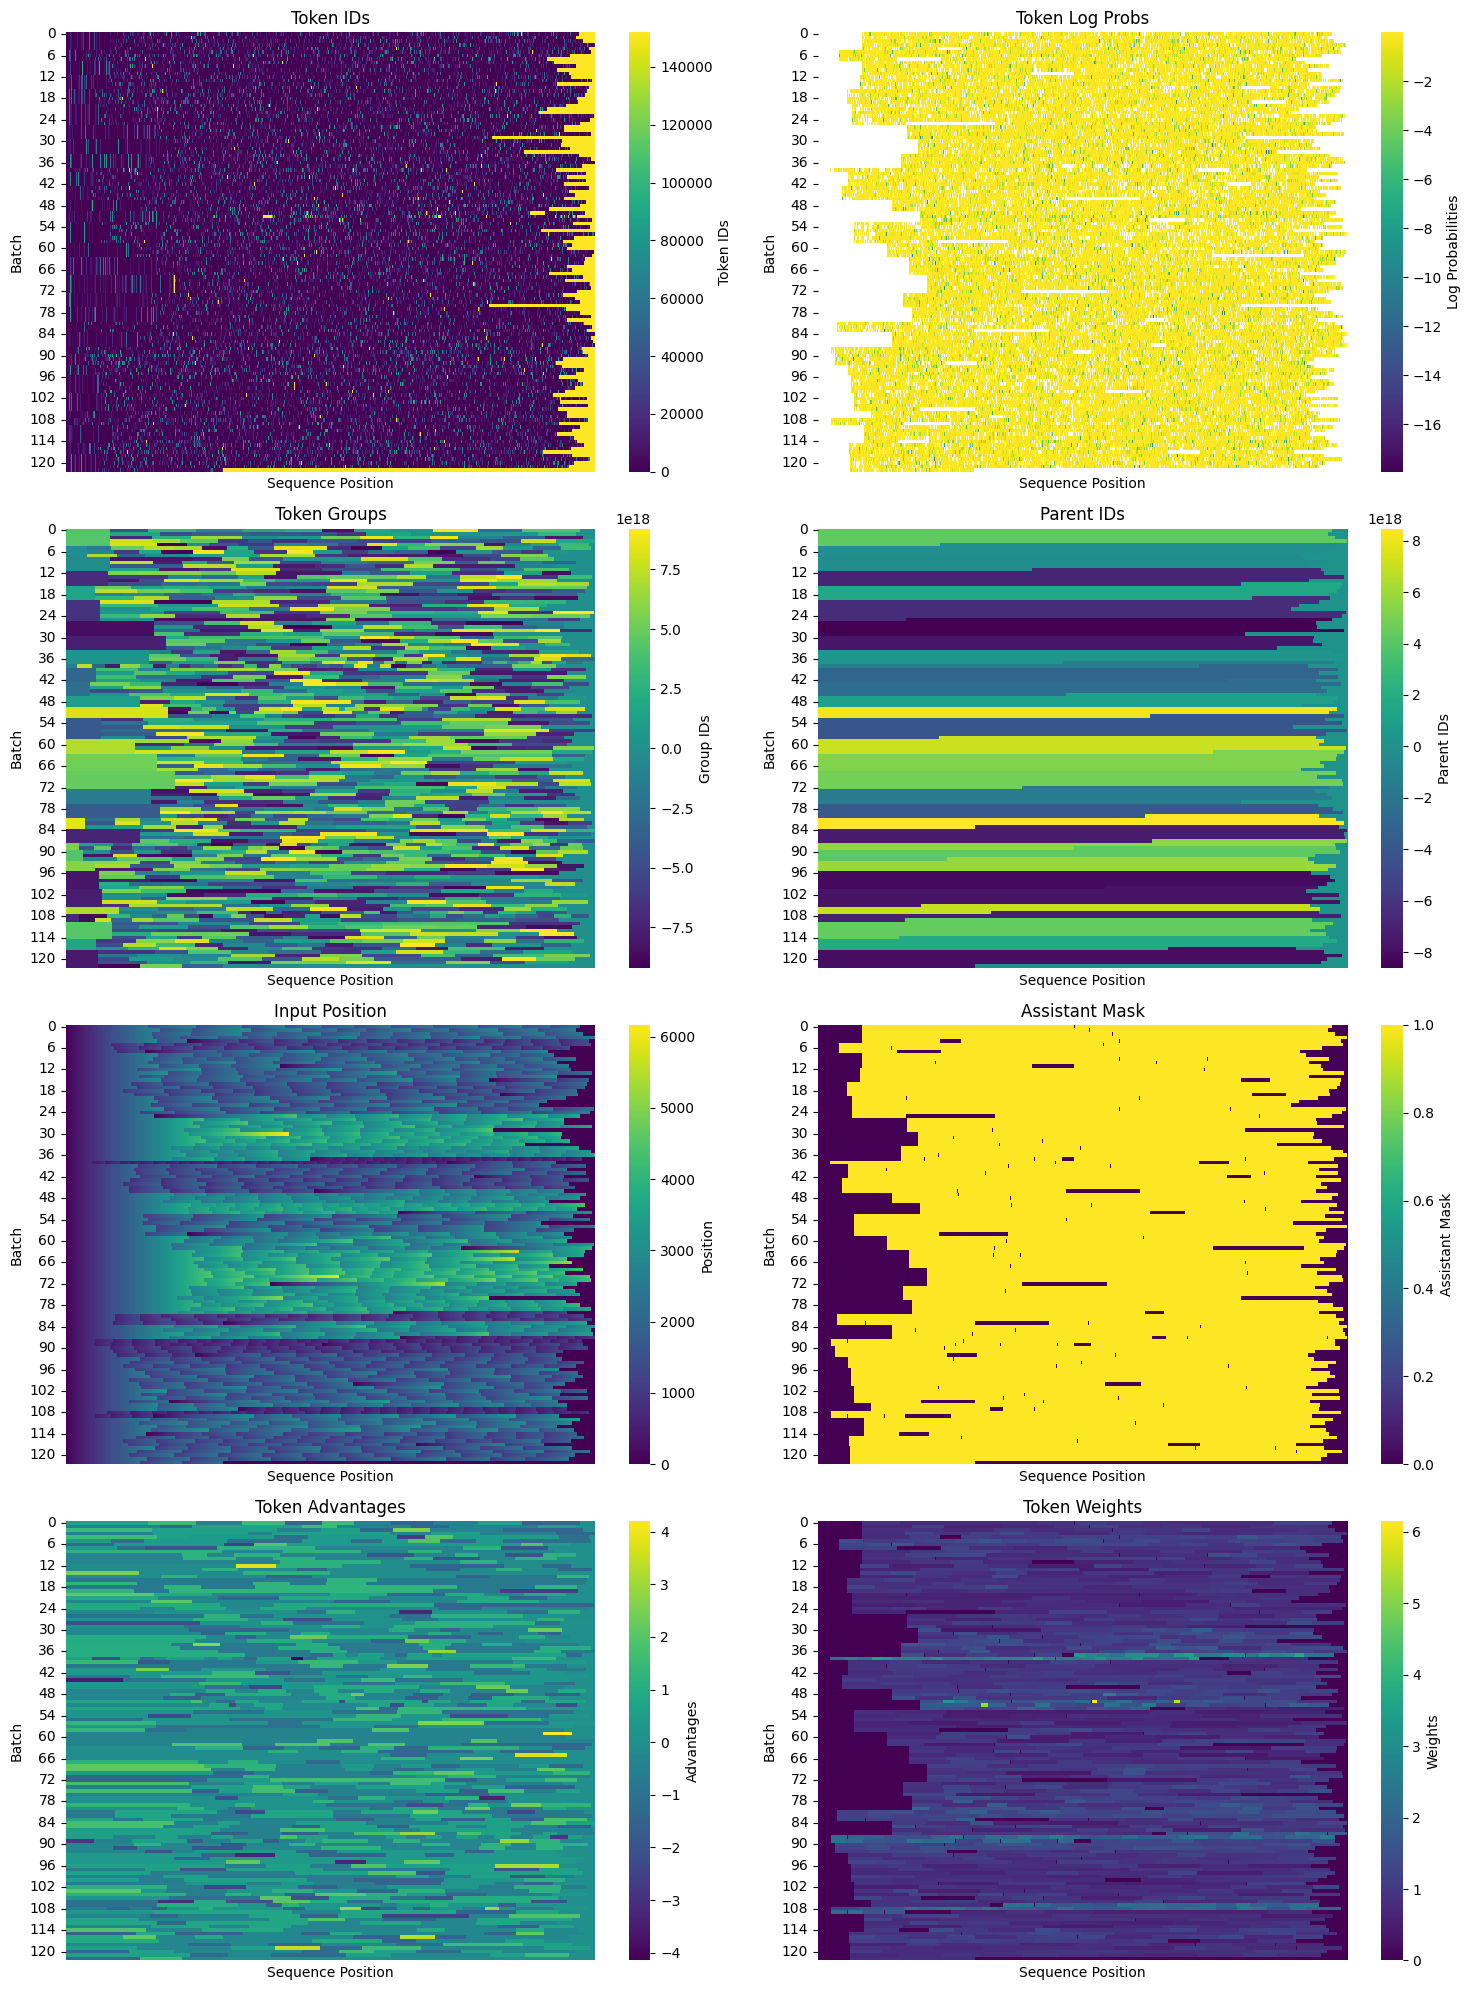

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 06:30:24.520000 210672 torch/distributed/run.py:793] 
W0223 06:30:24.520000 210672 torch/distributed/run.py:793] *****************************************
W0223 06:30:24.520000 210672 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 06:30:24.520000 210672 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0015
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-0

Writing logs to models/039/logs/log_1740292229.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.44 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|31|Loss: -0.0018: 100%|██████████| 31/31 [17:14<00:00, 32.63s/it, entropy=0.248, kl_div=nan, loss=-0.00183, policy=-0.00183]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/039/0016 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/039/0016 --port=8000 --api-key=default
INFO 02-23 06:49:23 __init__.py:190] Automatically detected platform cuda.
INFO 02-23 06:49:24 api_server.py:840] vLLM API server version 0.7.2
INFO 02-23 06:49:24 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/039/0016', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.53it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.56it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.56it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.13it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.10it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.88it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.76it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.68it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.76it/s]



INFO 02-23 06:49:46 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=222365) INFO 02-23 06:49:46 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=222365) INFO 02-23 06:49:50 worker.py:267] Memory profiling takes 3.46 seconds
(VllmWorkerProcess pid=222365) INFO 02-23 06:49:50 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=222365) INFO 02-23 06:49:50 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-23 06:49:50 worker.py:267] Memory profiling takes 3.54 seconds
INFO 02-23 06:49:50 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-23 06:49:50 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [220458]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-23 06:50:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:57190 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [06:41<00:00,  2.37s/it, completion_tokens=1249, prompt_tokens=1367, reward=0.395, acc=0.395, token_logprobs=2e+6]
Deleted iteration directory ./models/039/0011


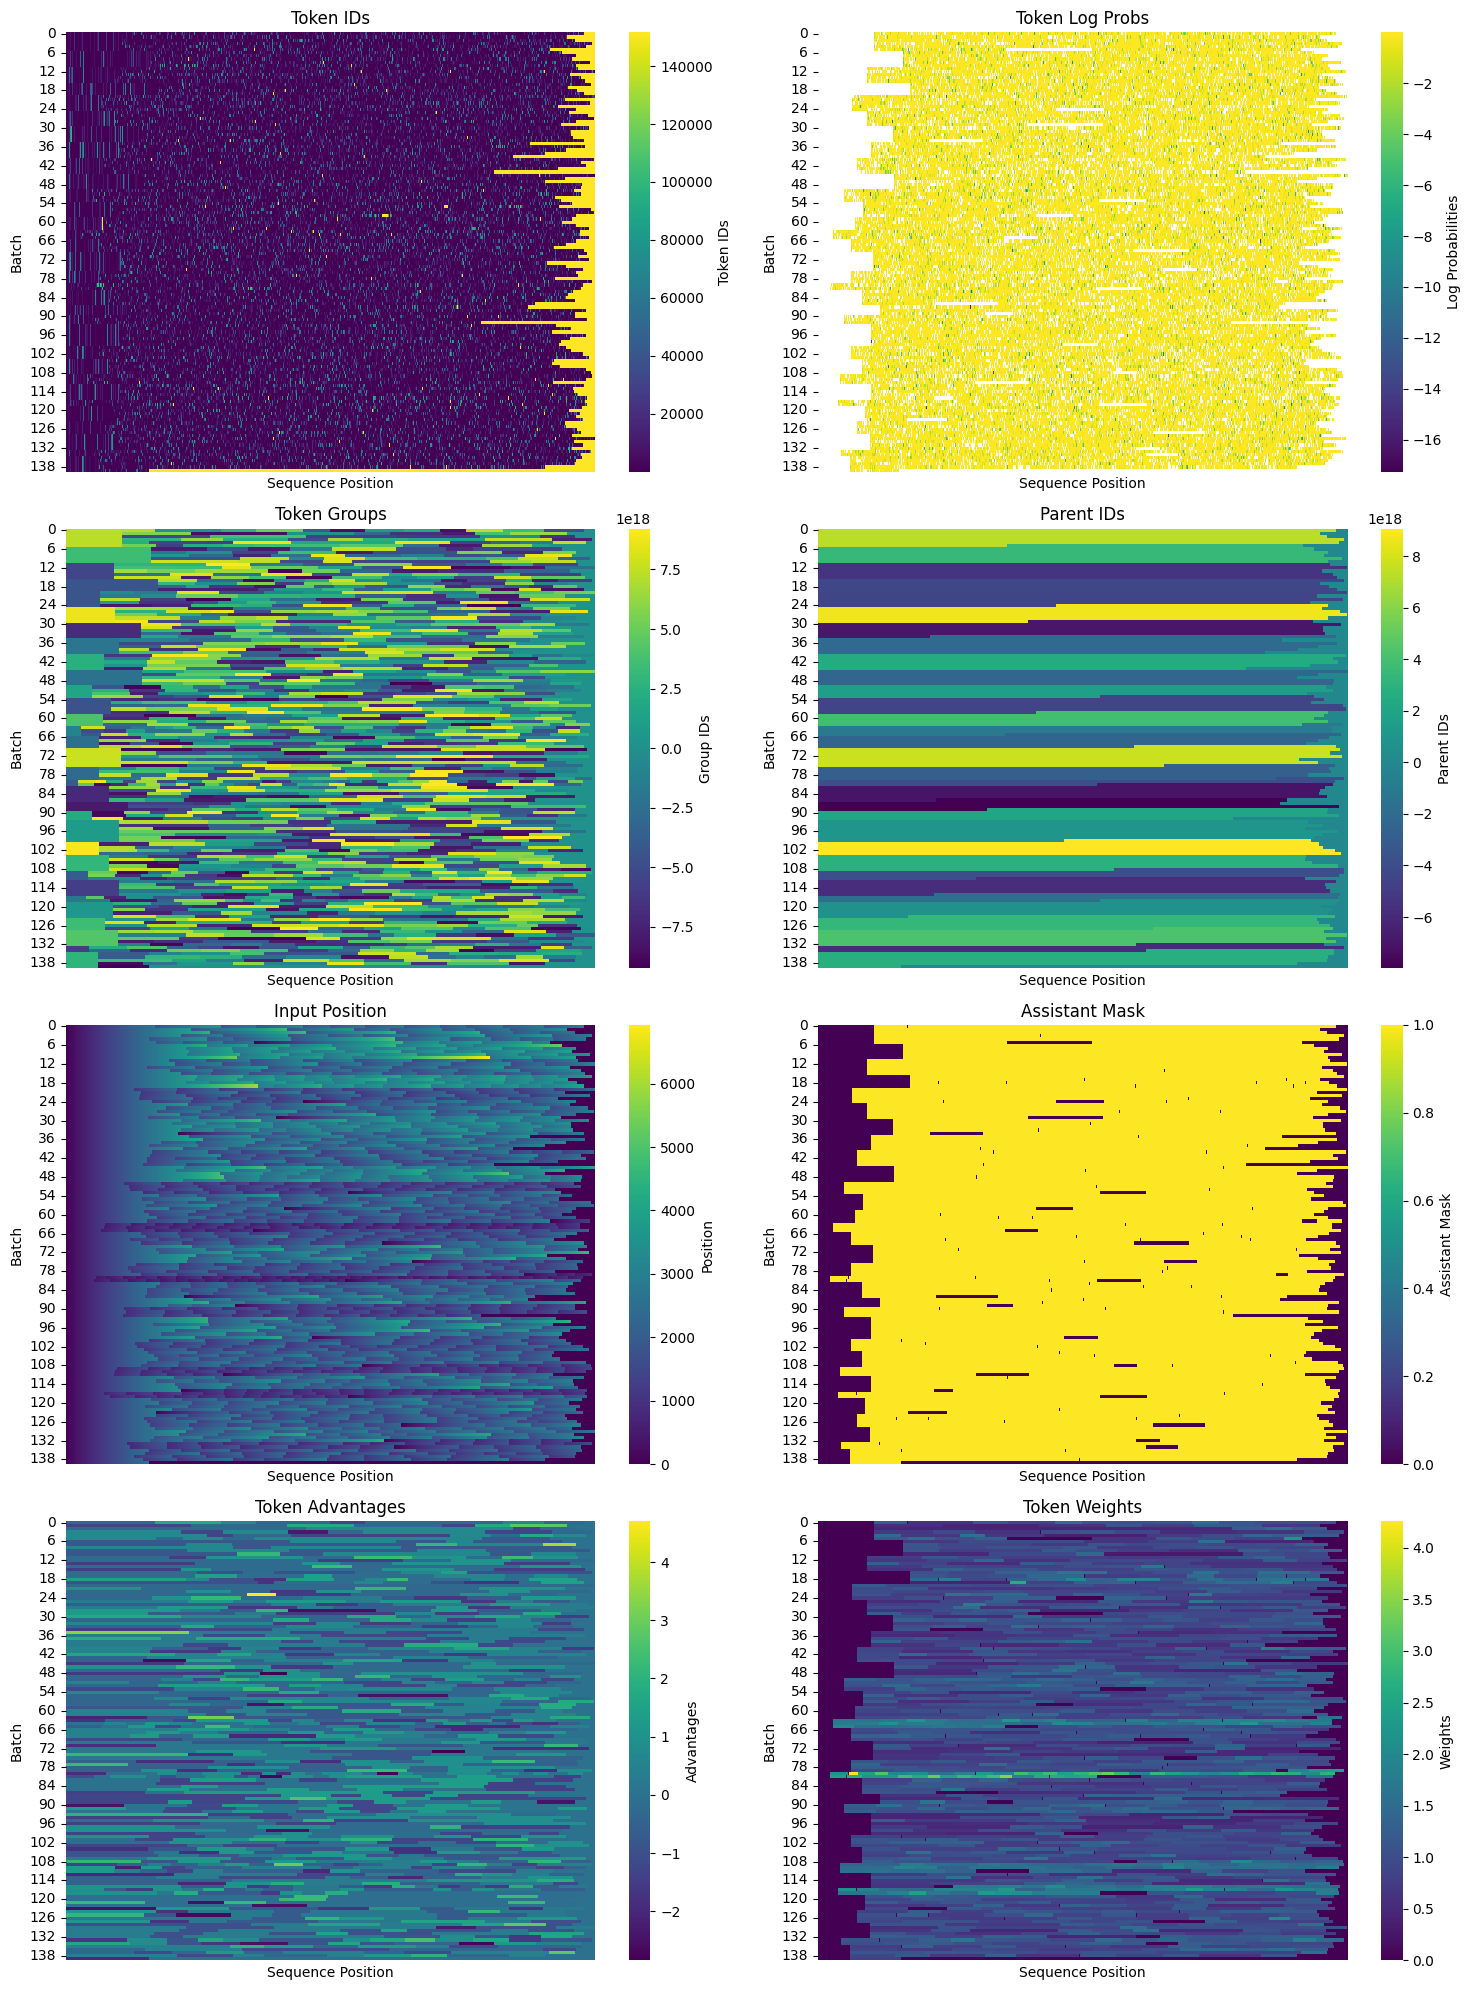

rsyncing /home/gcpuser/sky_workdir/experiments/models/039 to gs://atreides/openpipe/models/039
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/039/config.yaml
Running with torchrun...


W0223 06:58:05.640000 226150 torch/distributed/run.py:793] 
W0223 06:58:05.640000 226150 torch/distributed/run.py:793] *****************************************
W0223 06:58:05.640000 226150 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0223 06:58:05.640000 226150 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/039/0016
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-0

Writing logs to models/039/logs/log_1740293891.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 26.96 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0001:  17%|█▋        | 6/35 [03:39<16:25, 34.00s/it, entropy=0.203, kl_div=nan, loss=-8.68e-5, policy=-8.68e-5]  

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
        # see ./logs/rsync.log for output
        asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    except Exception:
        pass
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
            compile=True,
        ),
        verbosity=verbosity,
    )
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))

In [9]:
import glob
import os

epoch_dirs = lambda: glob.glob(f"{output_dir}/epoch_*")
epoch_dir = max(
    epoch_dirs(),
    key=lambda x: int(x.split("_")[-1]),
    default=None,
)
assert (
    epoch_dir is not None
), f"No epoch directory found in output directory {output_dir}"
iteration_dir = f"{output_dir}/{get_iteration(output_dir) + 1:04d}"
os.rename(epoch_dir, iteration_dir)
for epoch_dir in epoch_dirs():
    os.rmdir(epoch_dir)

./models/039/epoch_100 ./models/039/0002


In [5]:
from lib.pack import packed_tensors_from_dir

packed_tensors = packed_tensors_from_dir(
    dir="./models/038/tensors", num_sequences=75, sequence_length=16384
)

In [6]:
optimizer_config = ComponentConfig(
    model.tune_optimizer,
    lr=lr,
    betas=betas,
    weight_decay=weight_decay,
)
if model.tune_optimizer == "torch.optim.AdamW":
    optimizer_config.fused = True
model_name = await tune(
    base_model=model.base_model,
    output_dir=output_dir,
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=optimizer_config,
        loss=ComponentConfig(
            GRPO,
            clip_epsilon=clip_epsilon,
            entropy_coef=entropy_coef,
            kl_coef=kl_coef,
            tanh=tanh,
        ),
        shuffle=True,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=2,
        compile=True,
    ),
    verbosity=verbosity,
)

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/038/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - model-00003-of-00004.safetensors
  - model-00001-of-00004.safetensors
  - model-00004-of-00004.safetensors
  - model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/038
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/038/tensors
  num_sequences: 75
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation

Writing logs to models/038/logs/log_1740269320.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.43 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|37|Loss: -0.0131: 100%|██████████| 37/37 [13:48<00:00, 22.02s/it, entropy=0.697, kl_div=nan, loss=-0.0131, policy=-0.0131]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

AssertionError: No model checkpoint files found to save in output directory ./models/038